In [1]:
import math

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm.auto import tqdm

import ddpm_Time_Series_copy
import numpy as np
import pandas as pd
import torch

from sklearn.datasets import make_moons
from torch.utils.data import TensorDataset


import ddpm_Time_Series_copy
from ddpm_Time_Series_copy import TimeSeriesDataset , TimeSeriesTestDataset
from noise_scheduler import NoiseScheduler


import torch
from torch.utils.data import Dataset, DataLoader
import argparse
import os

from torch import nn
from torch.nn import functional as F
from tqdm.auto import tqdm

import matplotlib.pyplot as plt
import numpy as np

from positional_embeddings import PositionalEmbedding


from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn


#===========================

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model training 

In [2]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

config = {
  "data_path":  "../datasets/UTS/NAB/Twitter_volume_AAPL",
  "output_dir": "output",
  "train_batch_size": 16,
  "eval_batch_size": 16,
  "num_epochs": 25,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.1,
  "beta_end": 1,
  "save_model_epochs": 1
}


# Create Config object
config = Config(config)

In [3]:

# Continue with the rest of your training loop...

sequence_length = 1500
input_size = 1  # Assuming 1D time series data


# Assuming you have the rest of your code defined already...

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32, 64, 128 ,256,128,64,32 ,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)


# Set up dataset and dataloader
dataset = TimeSeriesDataset(config.data_path,sequence_length=150, stride=1,normalize=False)
# Shuffling: The dataloader is currently not shuffling the data (shuffle=False). For training, it's usually better to shuffle to prevent the model from learning sequence order. I've changed this to shuffle=True in the artifact.
# Dropping last batch: You might want to set drop_last=True in the DataLoader to ensure all batches are of the same size. This can be important for some operations.

dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)
# Adjust model initialization================================================================================================

# Set up dataset and dataloader for test data
test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=1500, stride=100, normalize=True) #mean=dataset.mean, std=dataset.std)

# Create dataloader for the test dataset
test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)

#================================================================================================

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=config.learning_rate,
)

Training model...


Epoch 0:   1%|          | 6/487 [00:00<00:19, 24.34it/s]

Epoch 24: 100%|██████████| 487/487 [00:15<00:00, 31.41it/s, loss=2.33e+3, step=24]

eval timesteps tensor([65, 64, 13, 17, 13, 59, 39, 31, 22, 86, 27, 23, 58, 54, 69, 22])


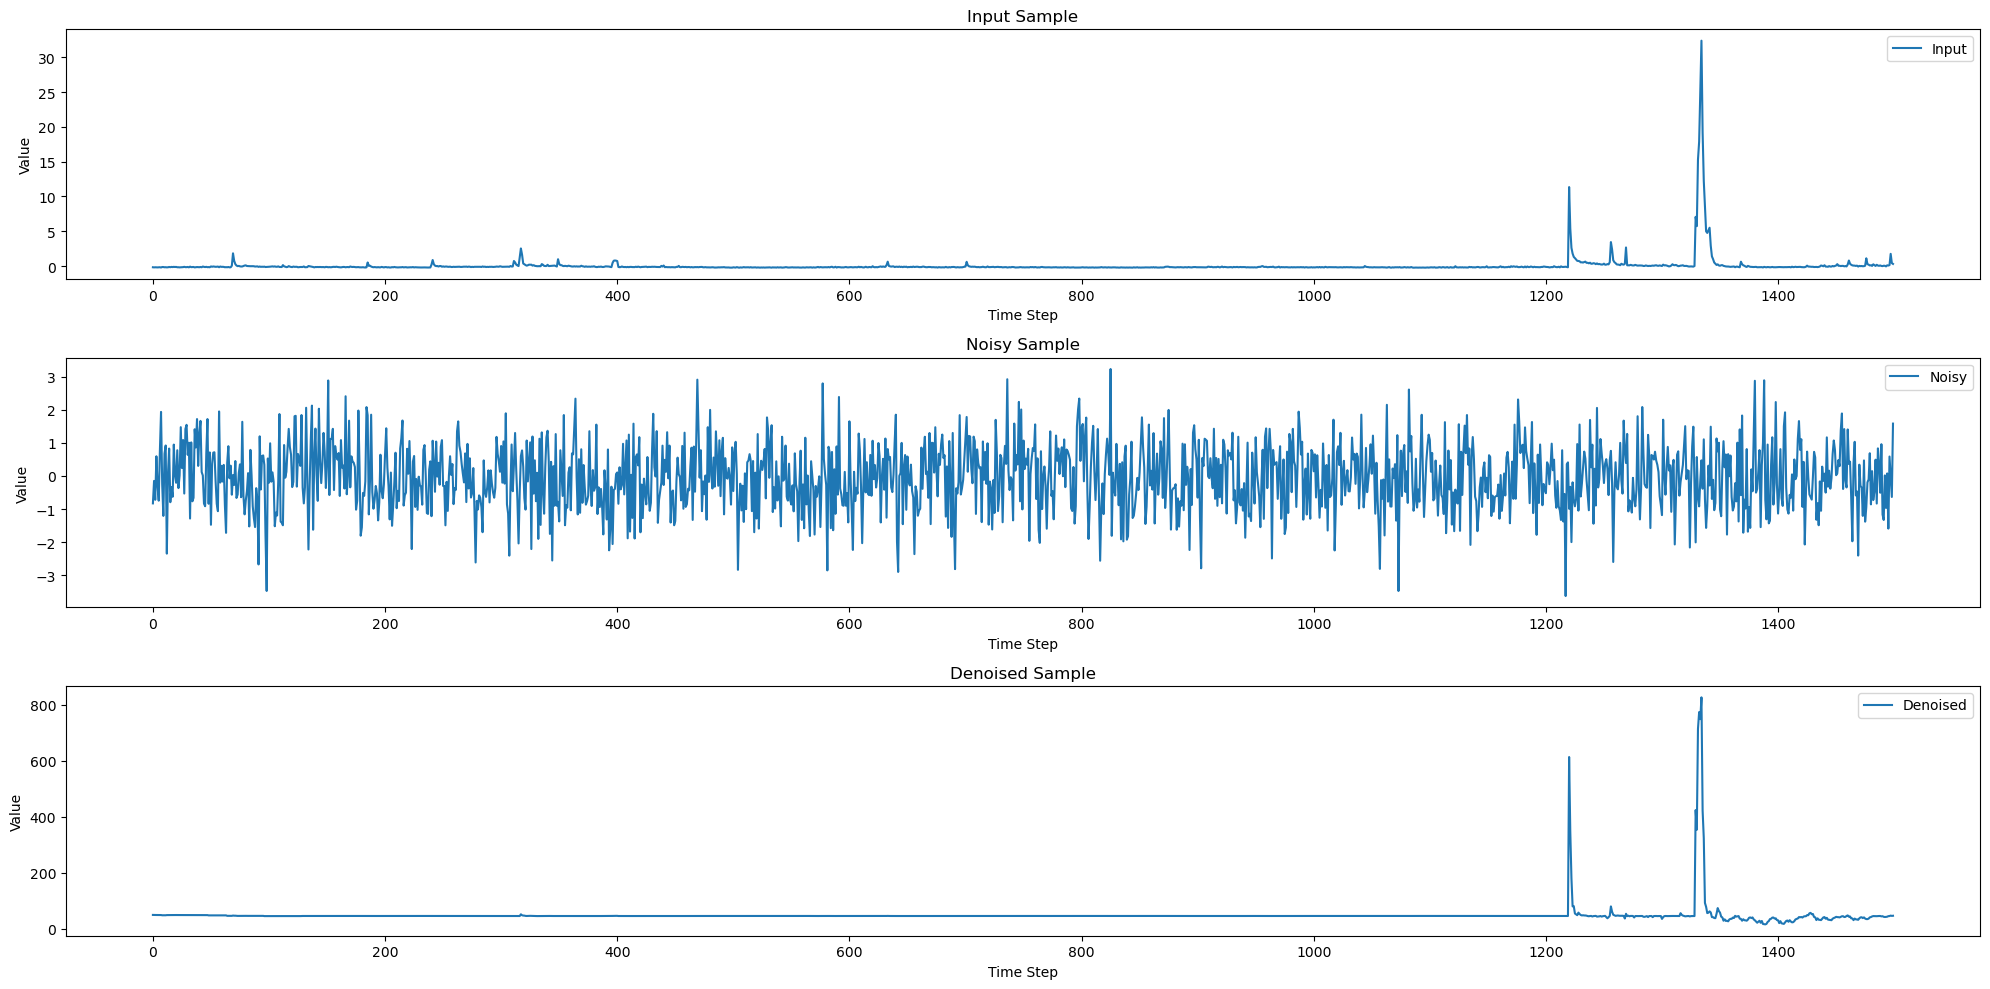

Epoch 24: 100%|██████████| 487/487 [00:16<00:00, 30.14it/s, loss=2.33e+3, step=24]


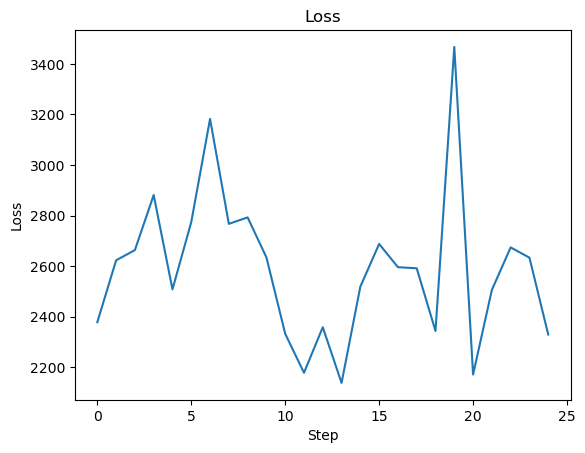

Model saved at output/25/model.pth
Losses saved at output/25/losses.json
Config saved at output/25/config.json


<Figure size 640x480 with 0 Axes>

In [4]:


# the training loop
global_step = 0
frames = []
losses = []
print("Training model...")
# Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
      
for epoch in range(config.num_epochs):
    model.train()
    progress_bar = tqdm(total=len(dataloader))
    progress_bar.set_description(f"Epoch {epoch}")
    
    for step, (batch, labels) in enumerate(dataloader): # timestamps,
        '''if model.input_shape == 'NCL':
            batch = batch.unsqueeze(1)  # Add channel dimension: (batch_size, 1, sequence_length)'''
        #elif model.input_shape == 'NLC':
            #batch = batch.unsqueeze(-1)  # Add channel dimension: (batch_size, sequence_length, 1)
        
        #noise = torch.randn_like(batch)
        
        # timesteps from o to num_timesteps
        #timesteps = torch.arange(0, noise_scheduler.num_timesteps).repeat(batch.shape[0], 1)
        
        #timesteps = torch.linspace(0, noise_scheduler.num_timesteps - 1, steps=batch.shape[0]).long()
        std_data = torch.std(batch)

        # I want the noise level increasing with epoch
        noise_level = 0.1 * (epoch+10)/5
        noise = torch.randn_like(batch) #* std_data * noise_level
                
        #noise = torch.randn_like(batch)
        
        timesteps = torch.randint(
            0, noise_scheduler.num_timesteps, (batch.shape[0],)
        ).long()
        
        # order the timesteps
        timesteps = timesteps.sort().values
        #print("timesteps", timesteps)
        
        noisy = noise_scheduler.add_noise(batch, noise, timesteps)
        
        noisy = noisy.unsqueeze(-1) 
        # pred noise from the model
        noise_pred = model(noisy)
        
        #print("noise_pred", noise_pred.shape)
        batch = batch.unsqueeze(-1)
        
        loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
        
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.update(1)
    logs = {"loss": loss.detach().item(), "step": global_step}
    losses.append(loss.detach().item())
    progress_bar.set_postfix(**logs)
    global_step += 1
    
   # Evaluation and visualization
    if (epoch % 50 == 0 or epoch == config.num_epochs - 1) and epoch != 0 :
        model.eval()
        eval_batch_size = config.eval_batch_size

        for step, (sample,  labels) in enumerate(tqdm(test_dataloader)):#timestamps,
            
            # after sapling random noise, predict using the model to denoise the sample
            with torch.no_grad():
                timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
                print("eval timesteps", timesteps)
                
                std_data = torch.std(sample)
                noise_level = 0.1
                noise = torch.randn_like(sample) #* std_data * noise_level
                noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
                
                noisy_sample = noisy_sample.unsqueeze(-1)
                sample = sample.unsqueeze(-1)
                denoised_sample = model(sample)
                
                # Visualize the input the noisy and denoised data
                
                fig, axs = plt.subplots(3, 1, figsize=(20, 10))
                
                ax = axs[0]
                ax.plot(sample[0].cpu().numpy())
                ax.set_title("Input Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Input"])
                
                ax = axs[1]
                ax.plot(noisy_sample[0].cpu().numpy())
                ax.set_title("Noisy Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Noisy"])
                
                ax = axs[2]
                ax.plot(denoised_sample[0].cpu().numpy())
                ax.set_title("Denoised Sample")
                ax.set_xlabel("Time Step")
                ax.set_ylabel("Value")
                ax.legend(["Denoised"])
                
                plt.tight_layout()
                plt.show()
                
            break
            

        
    progress_bar.close()
    
    
# save the model, losses and all the config parameters in a directory 
import os
import json

# output dir contains the num epochs 
output_dir = os.path.join(config.output_dir, str(config.num_epochs))
# create the directory if it does not exist
os.makedirs(output_dir, exist_ok=True) 

# Save the model
model_path = os.path.join(output_dir, "model.pth")
torch.save(model.state_dict(), model_path)

# Save the losses and the lother parameters in a json file 
losses_path = os.path.join(output_dir, "losses.json")
with open(losses_path, "w") as f:
    json.dump(losses, f)
    
# Save the config 
config_path = os.path.join(output_dir, "config.json")
with open(config_path, "w") as f:
    json.dump(vars(config), f)

# save the losses plot
# plot the loss
plt.plot(losses)
plt.title("Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.show()
losses_plot_path = os.path.join(output_dir, "losses_plot.png")
plt.savefig(losses_plot_path)
    
print("Model saved at", model_path)
print("Losses saved at", losses_path)
print("Config saved at", config_path)



# Evaluation and anomaly prediction one sample 

In [6]:
# import f1 score and auprc score for 0/1 classification

from sklearn.metrics import f1_score, average_precision_score, precision_score, recall_score

# define the function to calculate the f1 score and auprc score
def calculate_f1_auprc_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred,zero_division=0)
    #auprc = average_precision_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred,zero_division=0) 
    recall = recall_score(y_true, y_pred,zero_division=0)
    return f1, precision, recall


  0%|          | 0/4 [00:00<?, ?it/s]

eval timesteps tensor([38,  5, 25, 11, 66, 14, 18, 78, 37,  9, 44, 38, 24, 85, 25, 17])


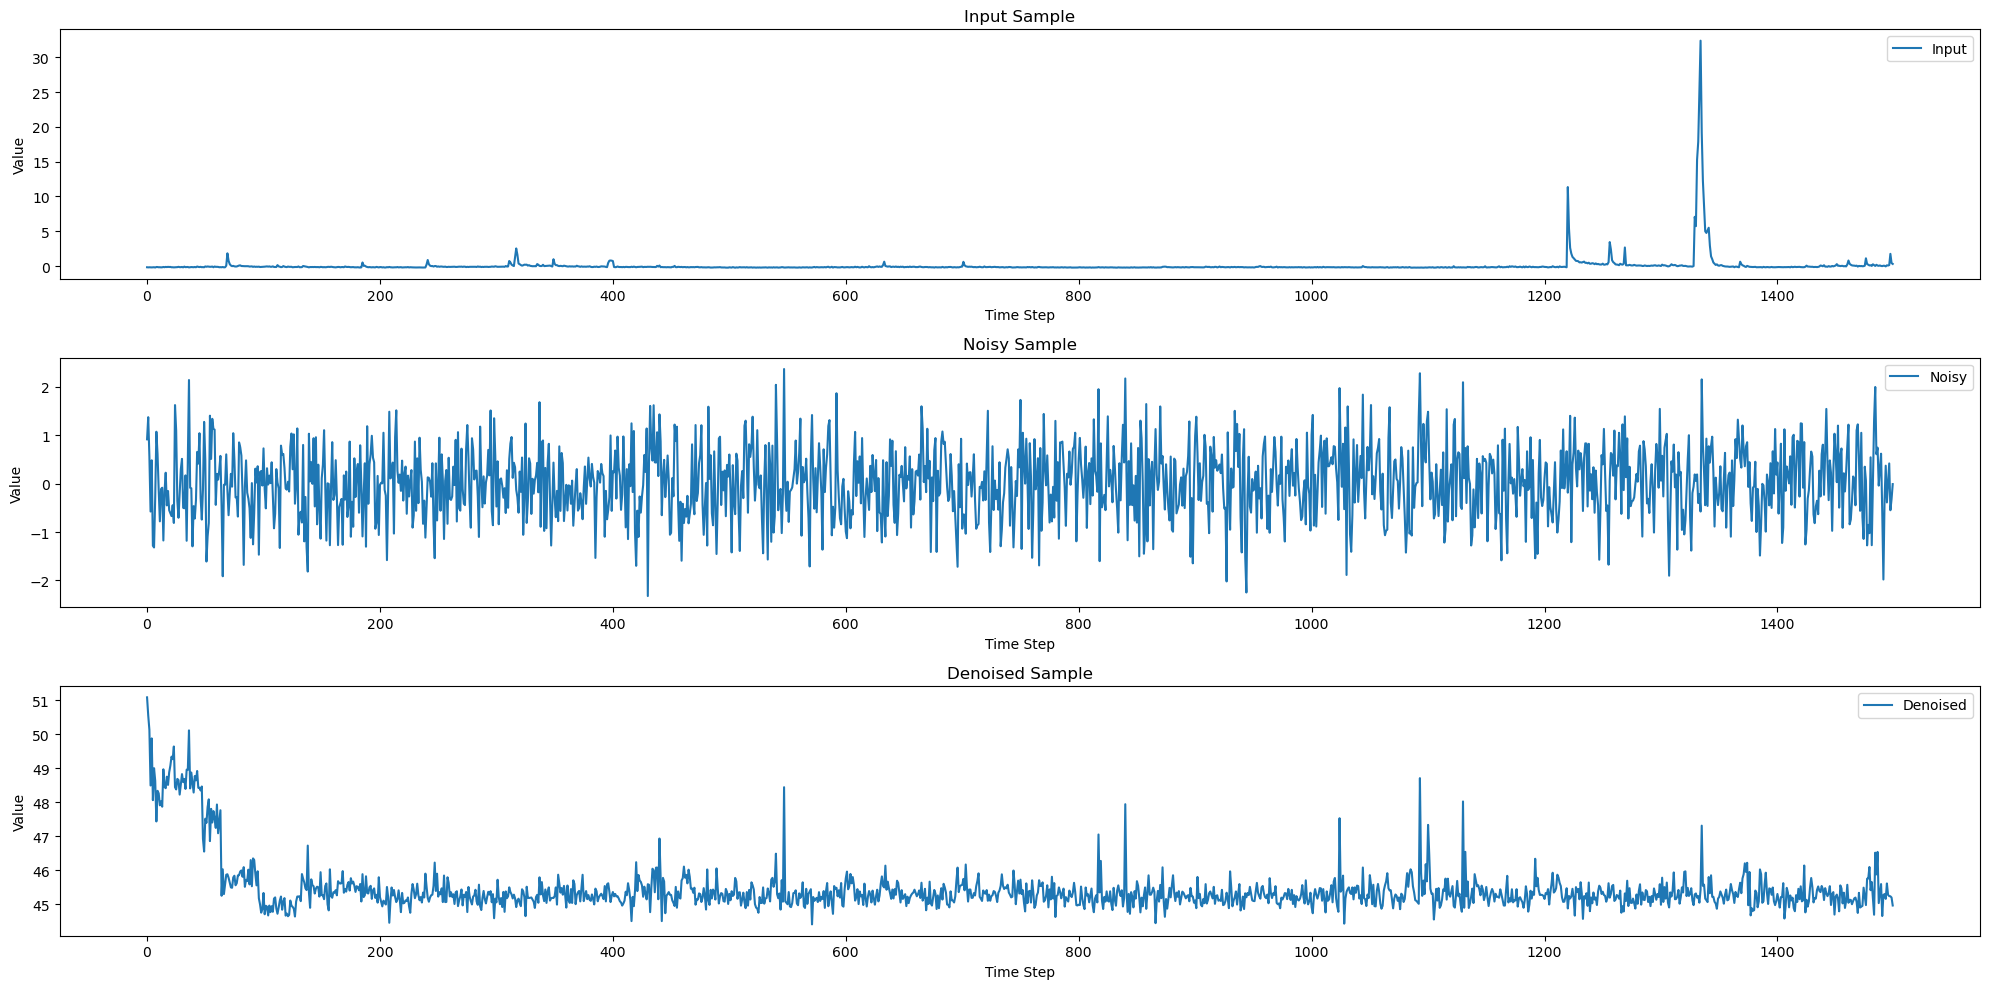

std_data tensor(1.4214)


<Figure size 640x480 with 0 Axes>

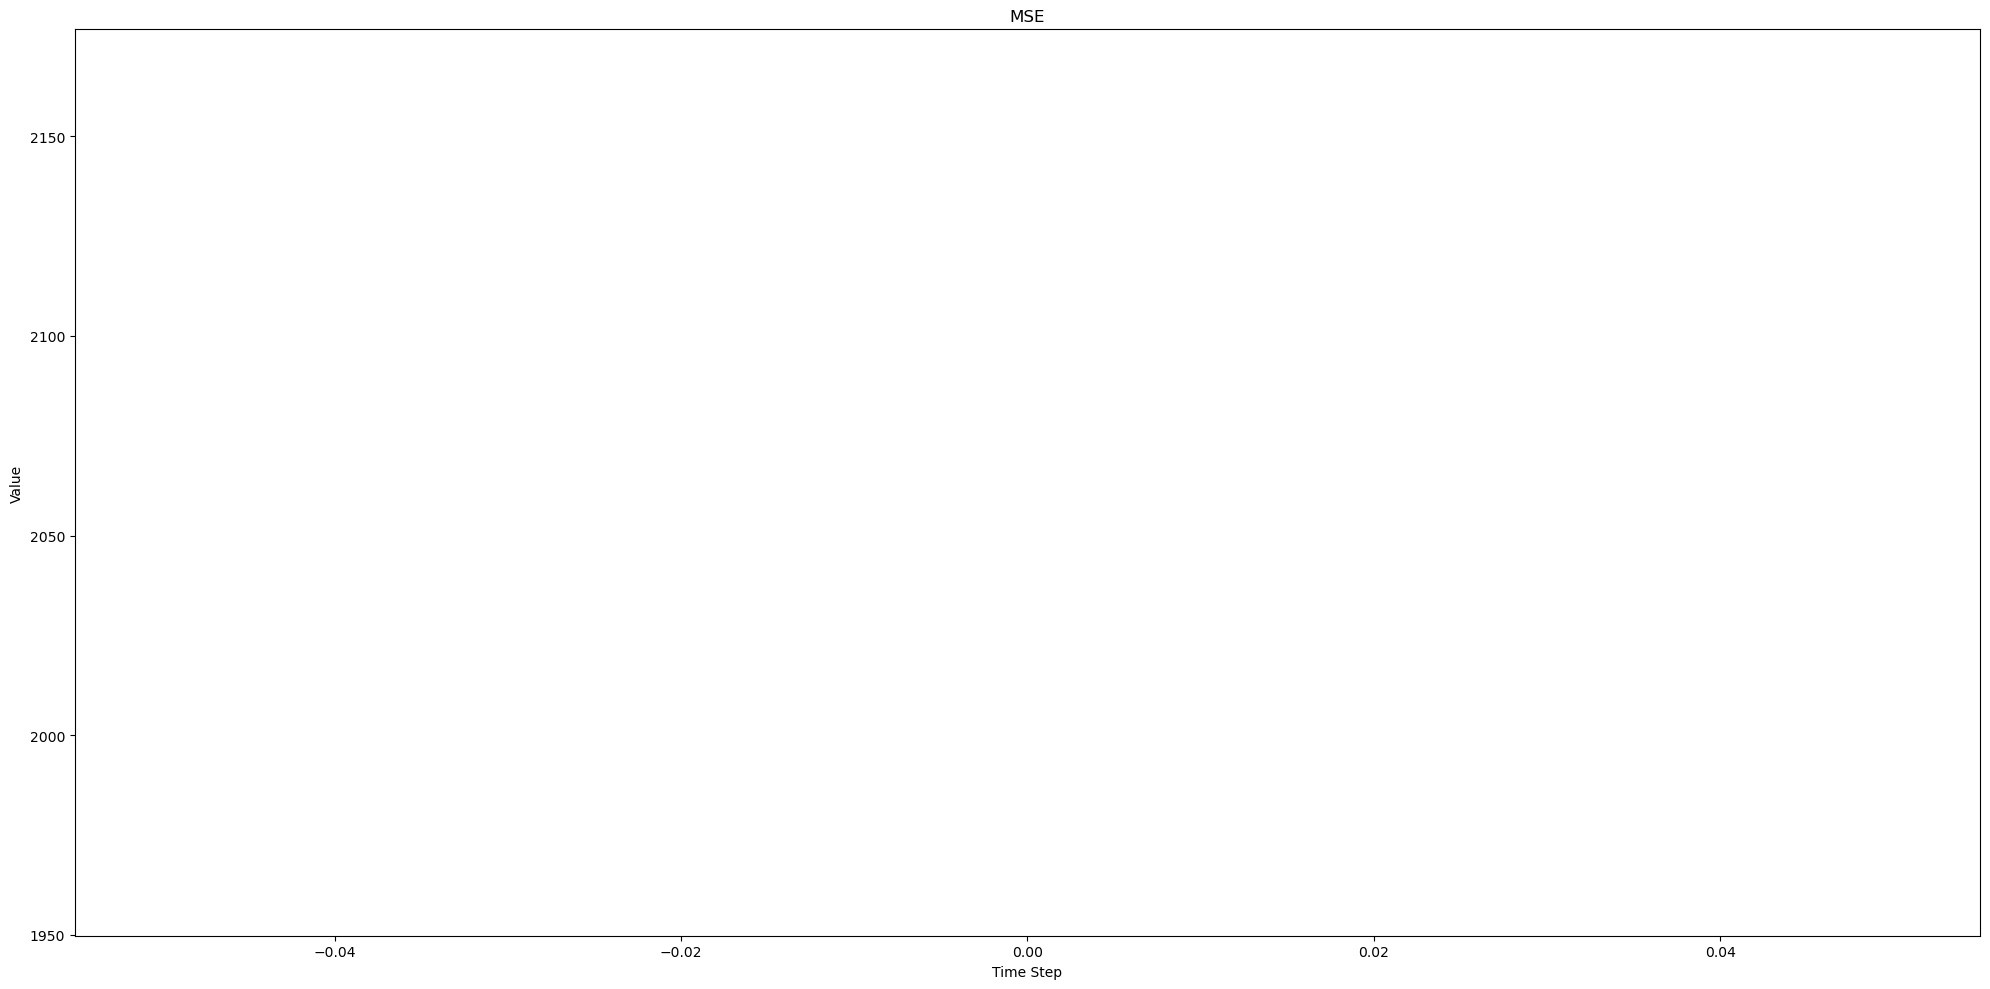

Outliers: [[[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]

 ...

 [[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]

 [[ True]
  [ True]
  [ True]
  ...
  [ True]
  [ True]
  [ True]]]
labels tensor([[0., 0., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.]], dtype=torch.float64)


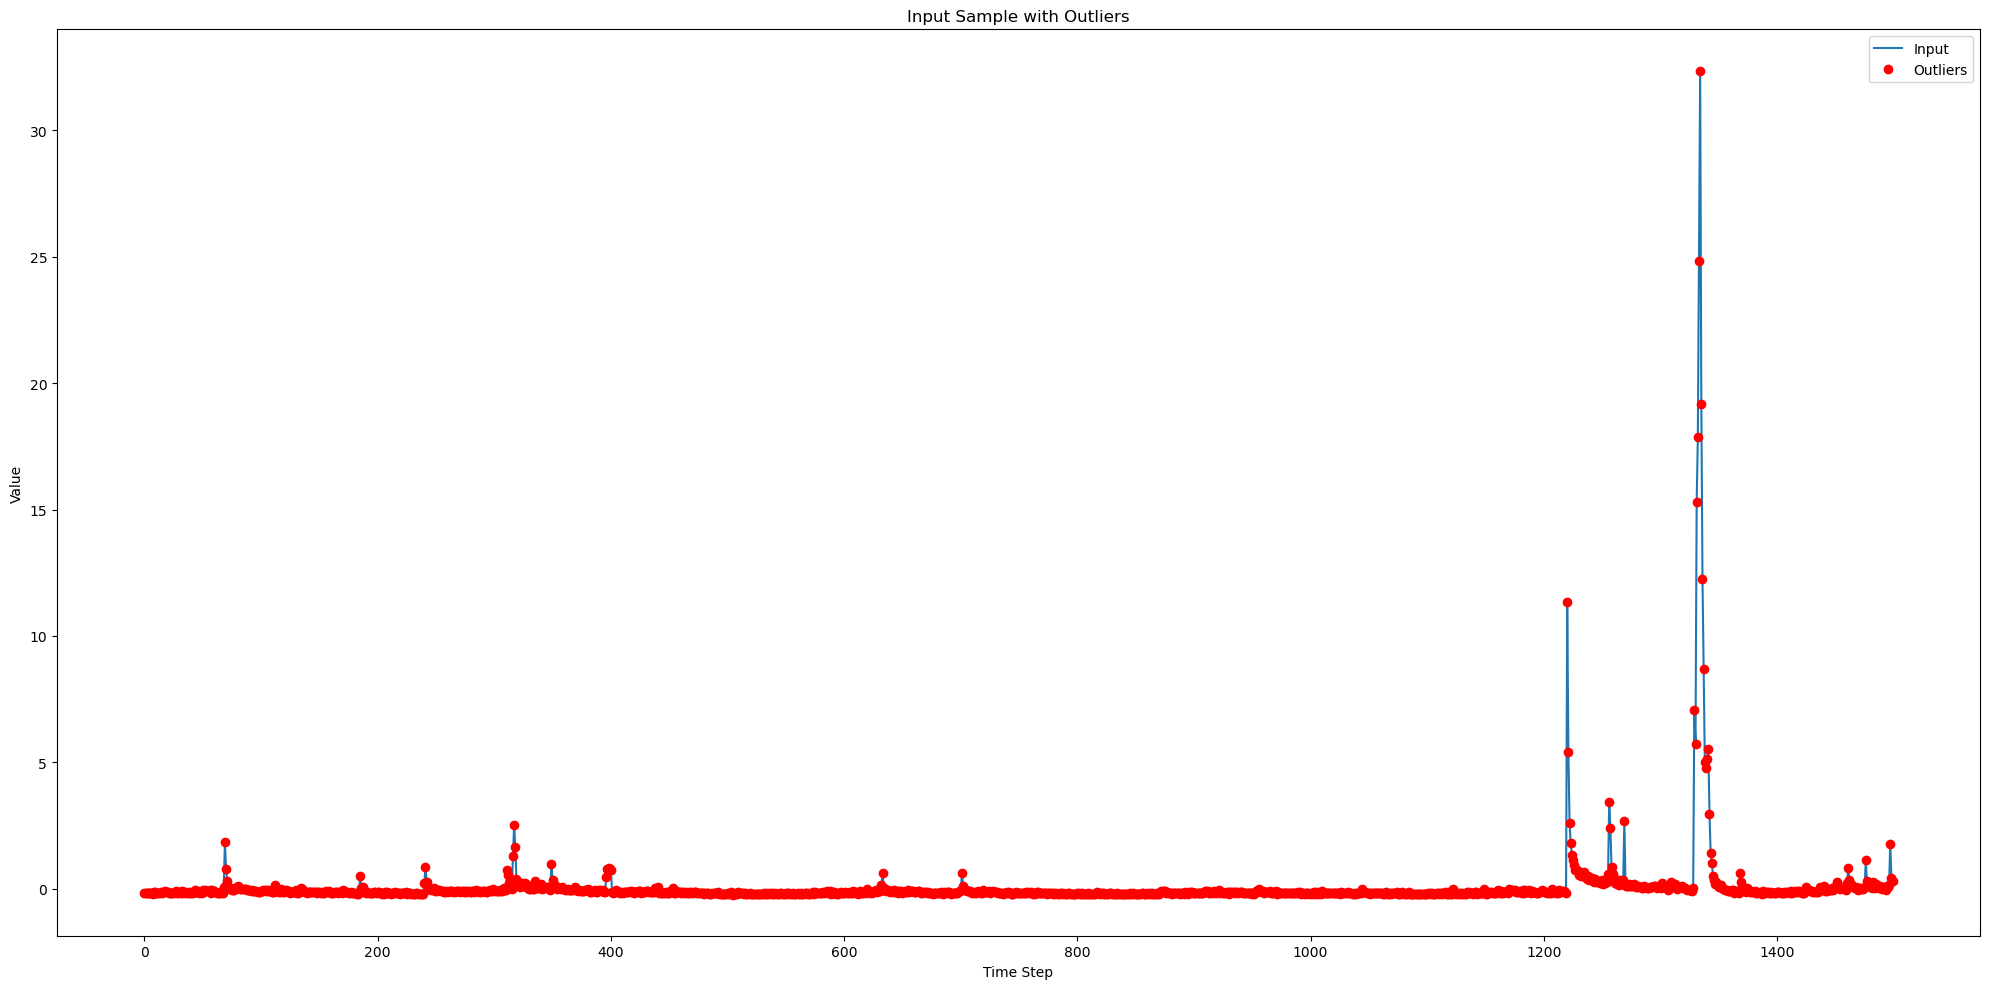

<Figure size 640x480 with 0 Axes>

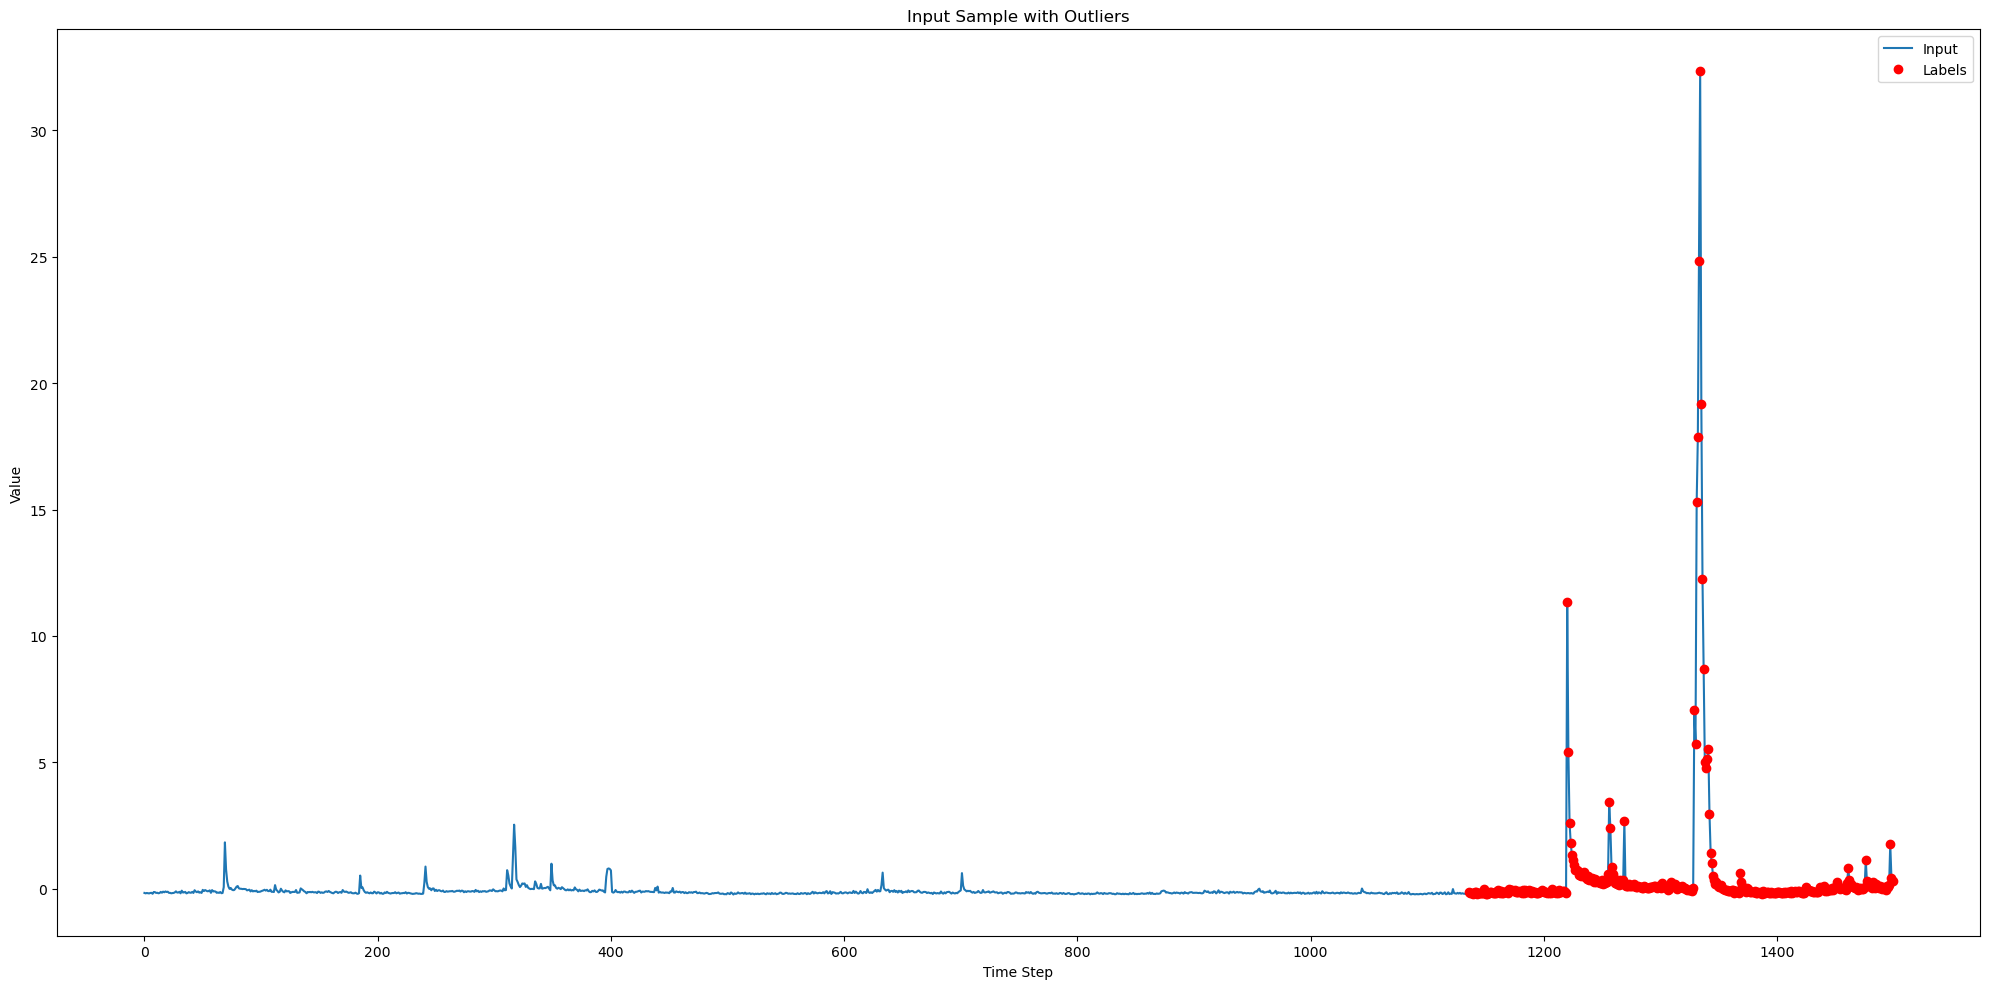

  0%|          | 0/4 [00:00<?, ?it/s]

Classification report


<Figure size 640x480 with 0 Axes>

In [17]:
model.eval()
eval_batch_size = config.eval_batch_size

for step, (sample,labels) in enumerate(tqdm(test_dataloader)): #  timestamps, 
    
    # after sapling random noise, predict using the model to denoise the sample
    with torch.no_grad():
        timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
        print("eval timesteps", timesteps)
    
        std_data = torch.std(sample)
        noise_level = 0.5
        noise = torch.randn_like(sample) * std_data * noise_level
        noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
        
        noisy_sample = noisy_sample.unsqueeze(-1)
        sample = sample.unsqueeze(-1)
        denoised_sample = model(noisy_sample)
        # Visualize the input the noisy and denoised data
        
        fig, axs = plt.subplots(3, 1, figsize=(20, 10))
        ax = axs[0]
        ax.plot(sample[0].cpu().numpy())
        ax.set_title("Input Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Input"])
        
        ax = axs[1]
        ax.plot(noisy_sample[0].cpu().numpy())
        ax.set_title("Noisy Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Noisy"])
        
        ax = axs[2]
        ax.plot(denoised_sample[0].cpu().numpy())
        ax.set_title("Denoised Sample")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend(["Denoised"])
        
        plt.tight_layout()
        plt.show()

        # save the fig 
        fig_path = os.path.join(output_dir, "sample_{}.png".format(step))
        plt.savefig(fig_path)
        
        # predict outlier points in the input sample by comparing the denoised sample with the input sample with a threshold
        print("std_data", std_data)
        threshold = std_data * 3

        outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
        
        # compute mse between the input and the denoised sample point 
        mse = F.mse_loss(sample[0], denoised_sample[0])

        # plot mse
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(mse.cpu().numpy())
        ax.set_title("MSE")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        plt.tight_layout()
        plt.show()
        
        #outliers = (torch.abs(mse) > threshold).cpu().numpy()
        #outliers 
        print("Outliers:", outliers)
        print("labels", labels)
        
        labels = labels.cpu().numpy()
        
        # calculate the f1 score and auprc score
        #f1, auprc, precision, recall = calculate_f1_auprc_score(labels[0], outliers[0])
        
        """print("Precision score:", precision)
        print("Recall score:", recall)
        print("F1 score:", f1)
        print("AUPRC score:", auprc)
        
        # save resutls in output directory
        results = {
            "f1": f1,
            "auprc": auprc
        }
        # save a json file with the results
        results_path = os.path.join(output_dir, "results.json")
        with open(results_path, "w") as f:
            json.dump(results, f)
        
        print("Results saved at", results_path)"""
        

        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        outlier_indices = np.where(outliers[0] == 1)[0]
        ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # save the fig
        fig_path = os.path.join(output_dir, "outliers_{}.png".format(step))
        plt.savefig(fig_path)
        
                
        # in the same graph visualize the input sample and the predicted outliers and the labels
        fig, ax = plt.subplots(figsize=(20, 10))
        ax.plot(sample[0].cpu().numpy(), label="Input")
    
        label_indices = np.where(labels[0] == True)[0]
        ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
        
        ax.set_title("Input Sample with Outliers")
        ax.set_xlabel("Time Step")
        ax.set_ylabel("Value")
        ax.legend()
        plt.tight_layout()
        plt.show()
        
        # save the fig
        fig_path = os.path.join(output_dir, "labels_{}.png".format(step))
        plt.savefig(fig_path)
        
        # classification report of outliers vs labels focus on the True positive, True negative, False positive and False negative
        print("Classification report")

        
        
    break


In [22]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    f1 = 0
    auprc = 0
    precision = 0
    recall = 0
    taille = 0
    
    for step, (sample, labels) in tqdm(enumerate(test_dataloader)): # timestamps,
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
            
            labels = labels.cpu().numpy()
                
            timesteps = torch.randint(0, noise_scheduler.num_timesteps, (eval_batch_size,)).long()
            #print("eval timesteps", timesteps)
        
            std_data = torch.std(sample)
            noise_level = 0.5
            noise = torch.randn_like(sample) * std_data * noise_level
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(sample) *2
            

            # computing the best threshold for the outliers
            for i in range(len(sample)):              
                best_f1 = 0
                best_threshold = 0
                best_auprc = 0
                best_precision = 0
                best_recall = 0
                
                for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                    outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                    
                    f1_temp, precision_temp, recall_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    
                    if f1_temp > best_f1:
                        best_f1 = f1_temp
                        best_threshold = threshold
                        best_precision = precision_temp
                        best_recall = recall_temp
                        
                """print("Best threshold:", best_threshold)
                print("Best F1 score:", best_f1)
                print("Best AUPRC score:", best_auprc)
                print("Best Precision score:", best_precision)
                print("Best Recall score:", best_recall)"""
            
            if best_f1 > 0:  
                f1 += best_f1
                precision += best_precision
                recall += best_recall
                taille += 1
                        # plot one random sample 
            if step == 0:
                plot_samples(sample[0], noisy_sample[0], denoised_sample[0])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
    f1 = f1 / taille
    auprc = auprc / taille
    precision = precision / taille
    recall = recall / taille
            
                
    print("F1 score:", f1 )
    print("AUPRC score:",auprc)
    print("Precision score:", precision)
    print("Recall score:", recall)
            

            


0it [00:00, ?it/s]

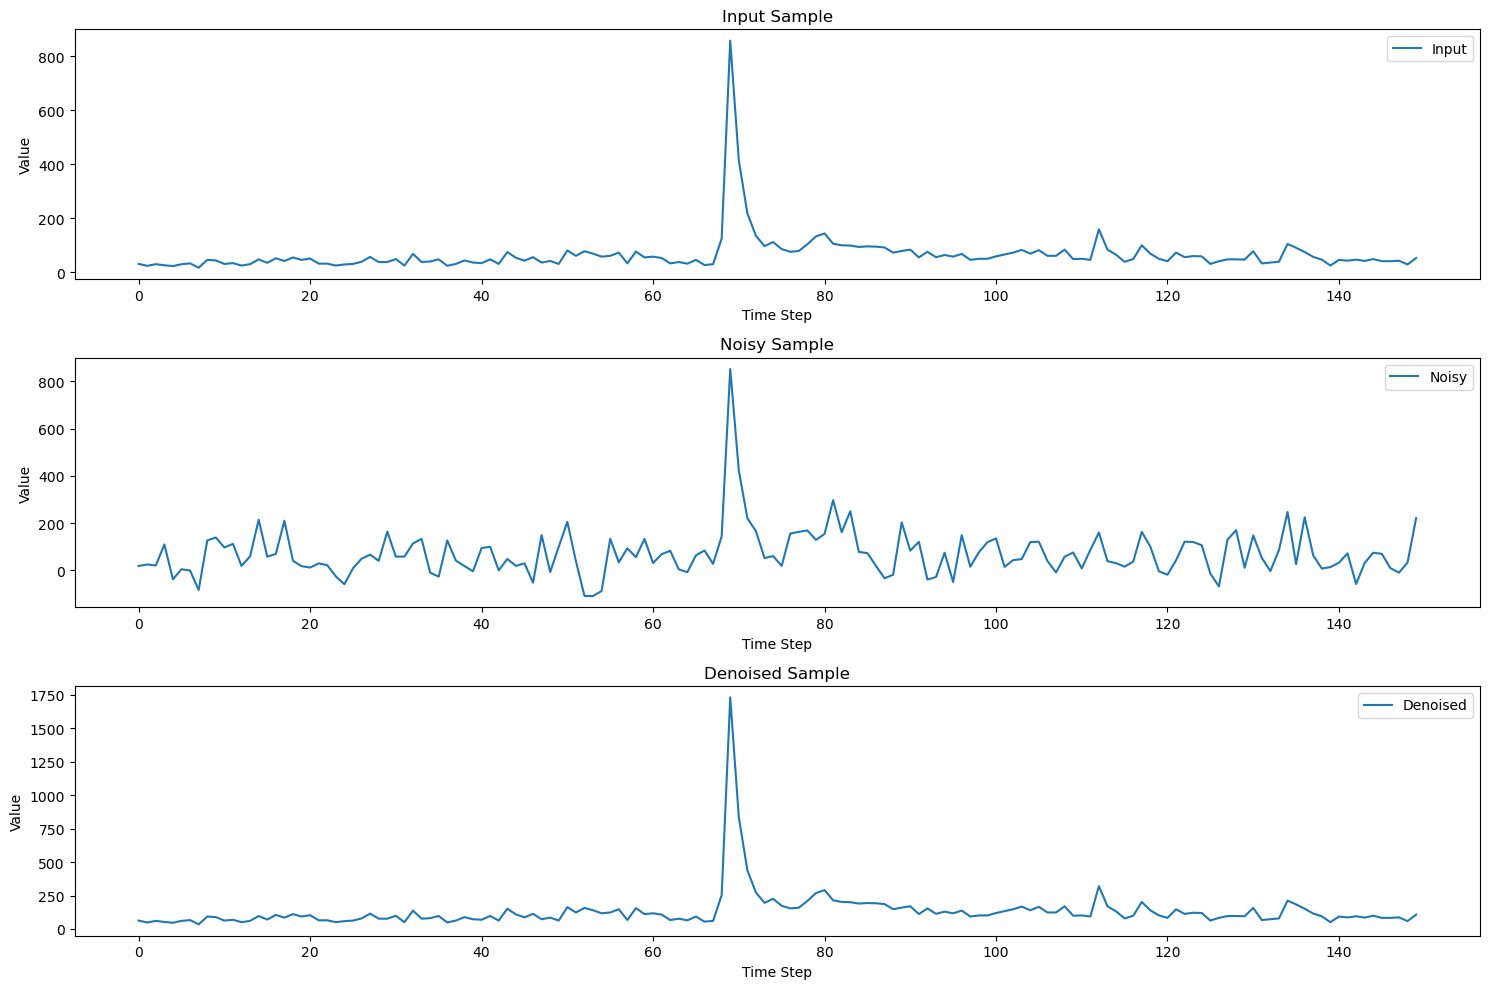

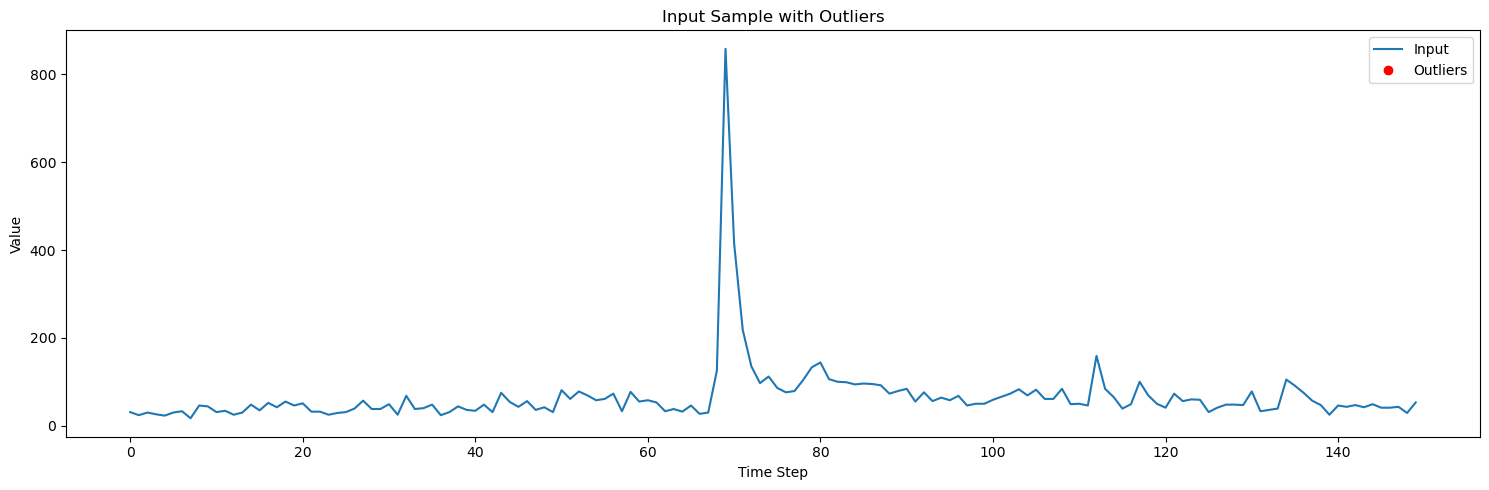

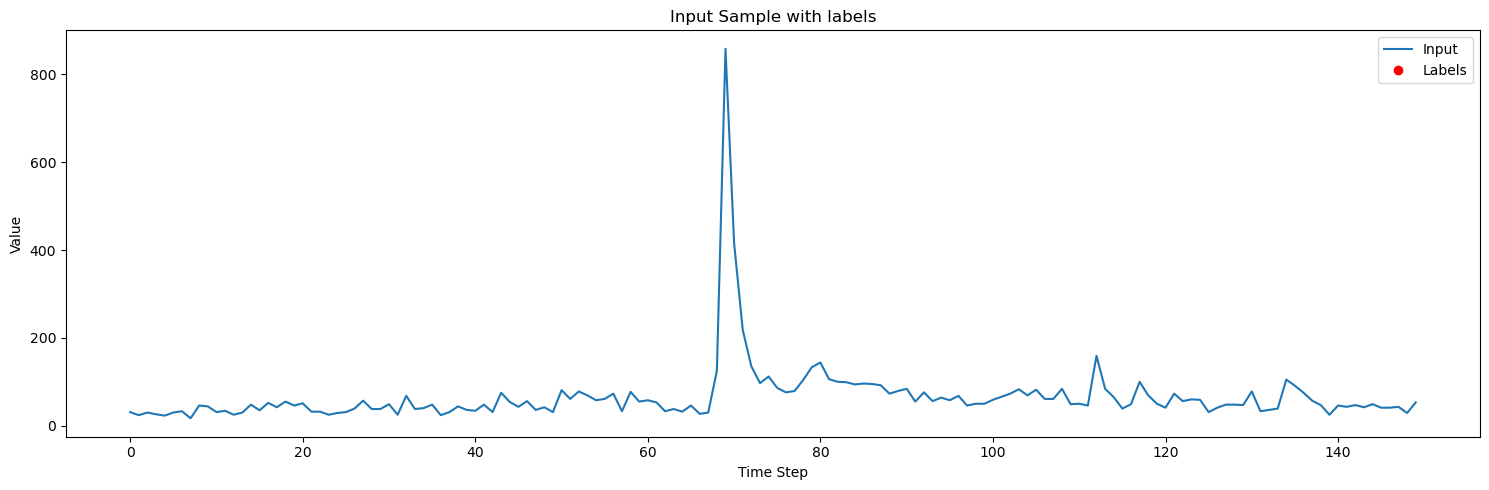

4it [00:01,  3.04it/s]

F1 score: 0.25
AUPRC score: 0.0
Precision score: 0.3181818181818182
Recall score: 0.20588235294117646


In [31]:
tester(config, model, noise_scheduler, test_dataset)

# Saving figures and results : 

## WSD107

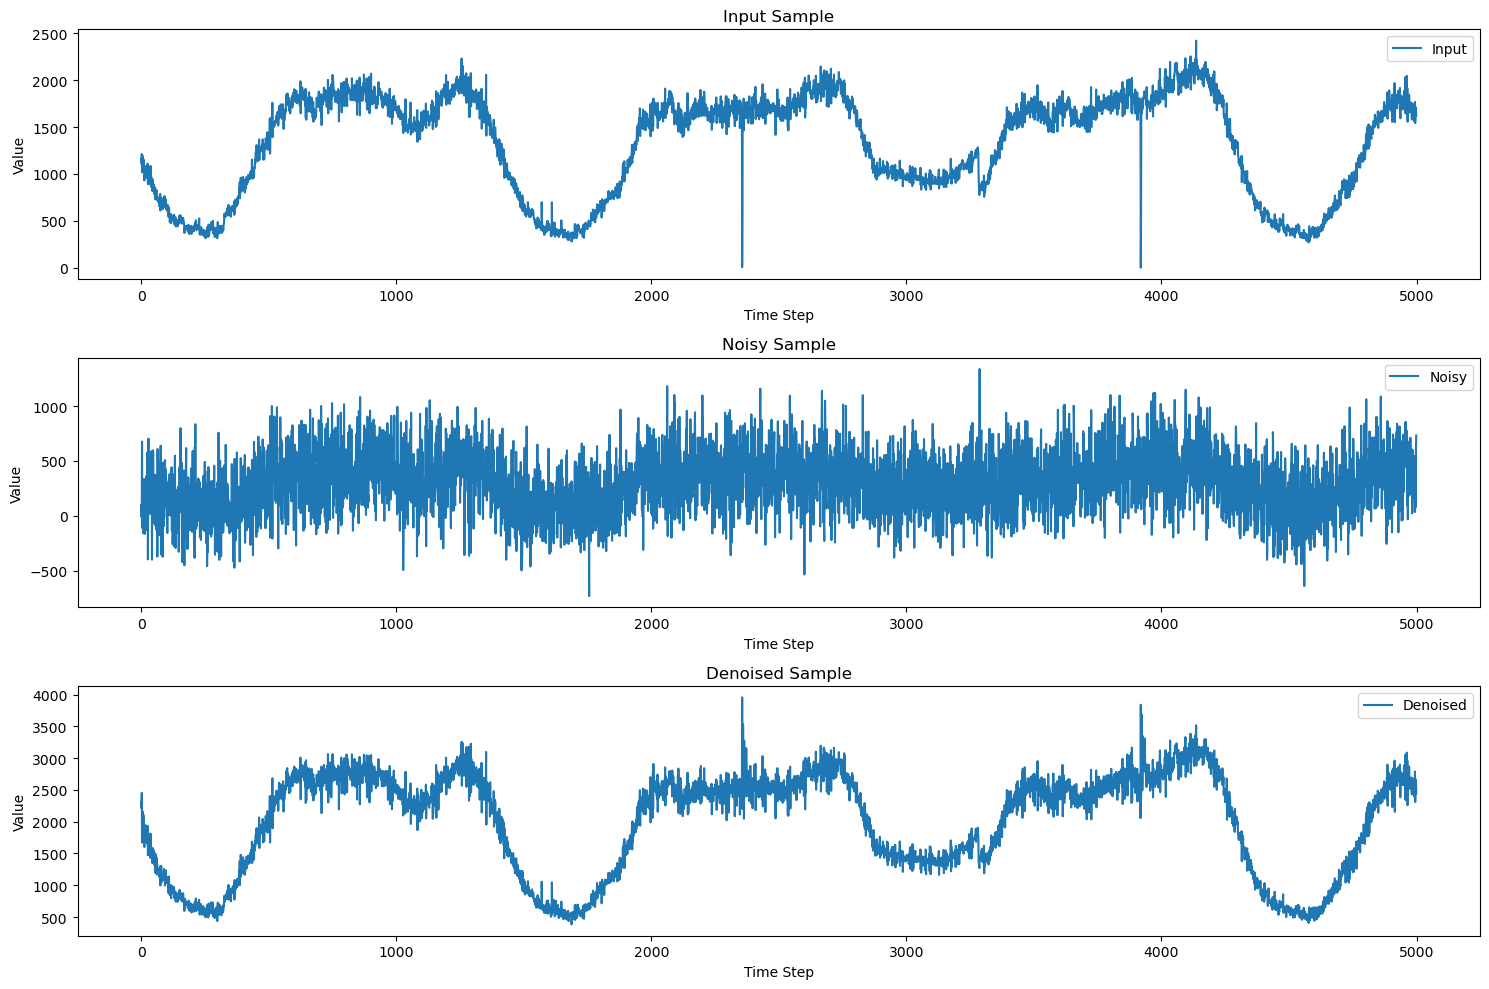

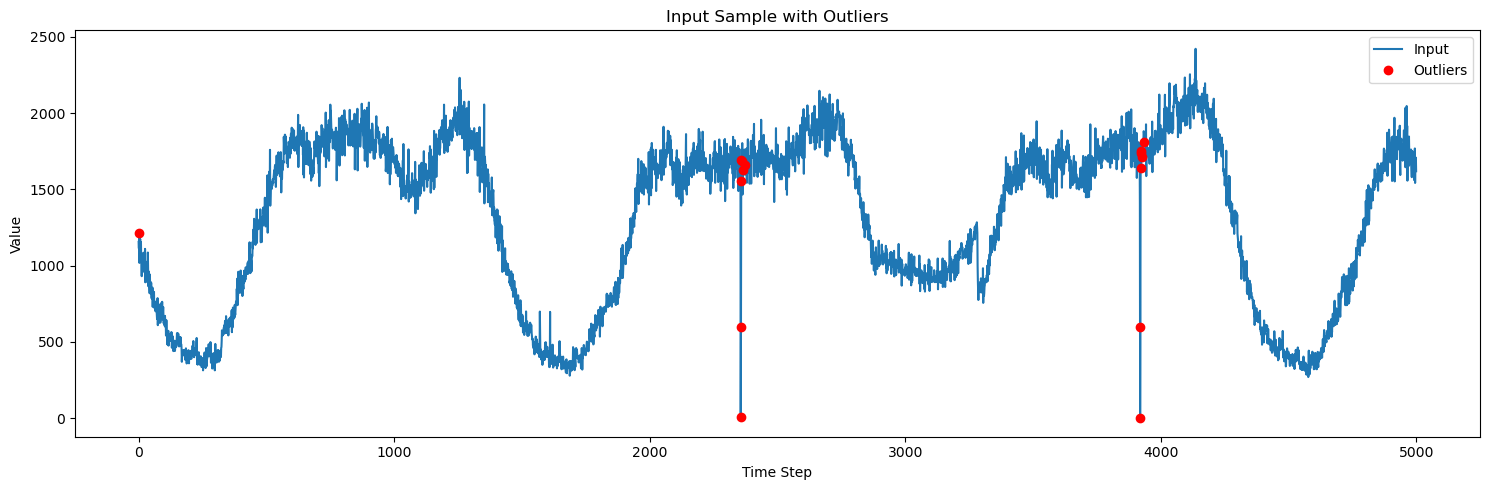

eval timesteps tensor([537, 118,  19, 188, 726, 399, 723, 277, 863, 421, 150, 248, 968, 352,
        256,  21])
Best threshold: tensor(1214.1018)
Best F1 score: 0.4489795918367347
Best AUPRC score: 0.2418549019607843
Best Precision score: 0.7333333333333333
Best Recall score: 0.3235294117647059
Best threshold: tensor(1214.1018)
Best F1 score: 0.3333333333333333
Best AUPRC score: 0.1385217391304348
Best Precision score: 0.55
Best Recall score: 0.2391304347826087
Best threshold: tensor(1214.1018)
Best F1 score: 0.26506024096385544
Best AUPRC score: 0.08902645502645501
Best Precision score: 0.4074074074074074
Best Recall score: 0.19642857142857142
Best threshold: tensor(1108.5278)
Best F1 score: 0.3488372093023256
Best AUPRC score: 0.14212857142857144
Best Precision score: 0.5
Best Recall score: 0.26785714285714285
Best threshold: tensor(1108.5278)
Best F1 score: 0.2988505747126437
Best AUPRC score: 0.10427777777777776
Best Precision score: 0.3333333333333333
Best Recall score: 0.2708333333333333
Best threshold: tensor(1214.1018)
Best F1 score: 0.2937062937062937
Best AUPRC score: 0.11151052631578946
Best Precision score: 0.4375
Best Recall score: 0.22105263157894736
Best threshold: tensor(1108.5278)
Best F1 score: 0.35064935064935066
Best AUPRC score: 0.14366244424620875
Best Precision score: 0.4576271186440678
Best Recall score: 0.28421052631578947
Best threshold: tensor(1108.5278)
Best F1 score: 0.30917874396135264
Best AUPRC score: 0.11097254021698467
Best Precision score: 0.32323232323232326
Best Recall score: 0.2962962962962963
Best threshold: tensor(1214.1018)
Best F1 score: 0.24539877300613497
Best AUPRC score: 0.07307727546714889
Best Precision score: 0.25316455696202533
Best Recall score: 0.23809523809523808
Best threshold: tensor(1108.5278)
Best F1 score: 0.35294117647058826
Best AUPRC score: 0.14386813186813188
Best Precision score: 0.46153846153846156
Best Recall score: 0.2857142857142857
Best threshold: tensor(1214.1018)
Best F1 score: 0.3076923076923077
Best AUPRC score: 0.11631966873706004
Best Precision score: 0.43478260869565216
Best Recall score: 0.23809523809523808
Best threshold: tensor(1214.1018)
Best F1 score: 0.30303030303030304
Best AUPRC score: 0.10299259259259258
Best Precision score: 0.3333333333333333
Best Recall score: 0.2777777777777778
Best threshold: tensor(1214.1018)
Best F1 score: 0.42105263157894735
Best AUPRC score: 0.2039034213098729
Best Precision score: 0.6060606060606061
Best Recall score: 0.3225806451612903
Best threshold: tensor(1214.1018)
Best F1 score: 0.4233576642335766
Best AUPRC score: 0.18830085470085473
Best Precision score: 0.4461538461538462
Best Recall score: 0.4027777777777778
Best threshold: tensor(1214.1018)
Best F1 score: 0.32323232323232326
Best AUPRC score: 0.12260298507462686
Best Precision score: 0.23880597014925373
Best Recall score: 0.5
Best threshold: tensor(1214.1018)
Best F1 score: 0.47368421052631576
Best AUPRC score: 0.23758260869565218
Best Precision score: 0.6
Best Recall score: 0.391304347826087
F1 score: 0.34368654551477423
AUPRC score: 0.14191265590930915
Precision score: 0.4447670561777277
Recall score: 0.2972302286753181

## NAB 

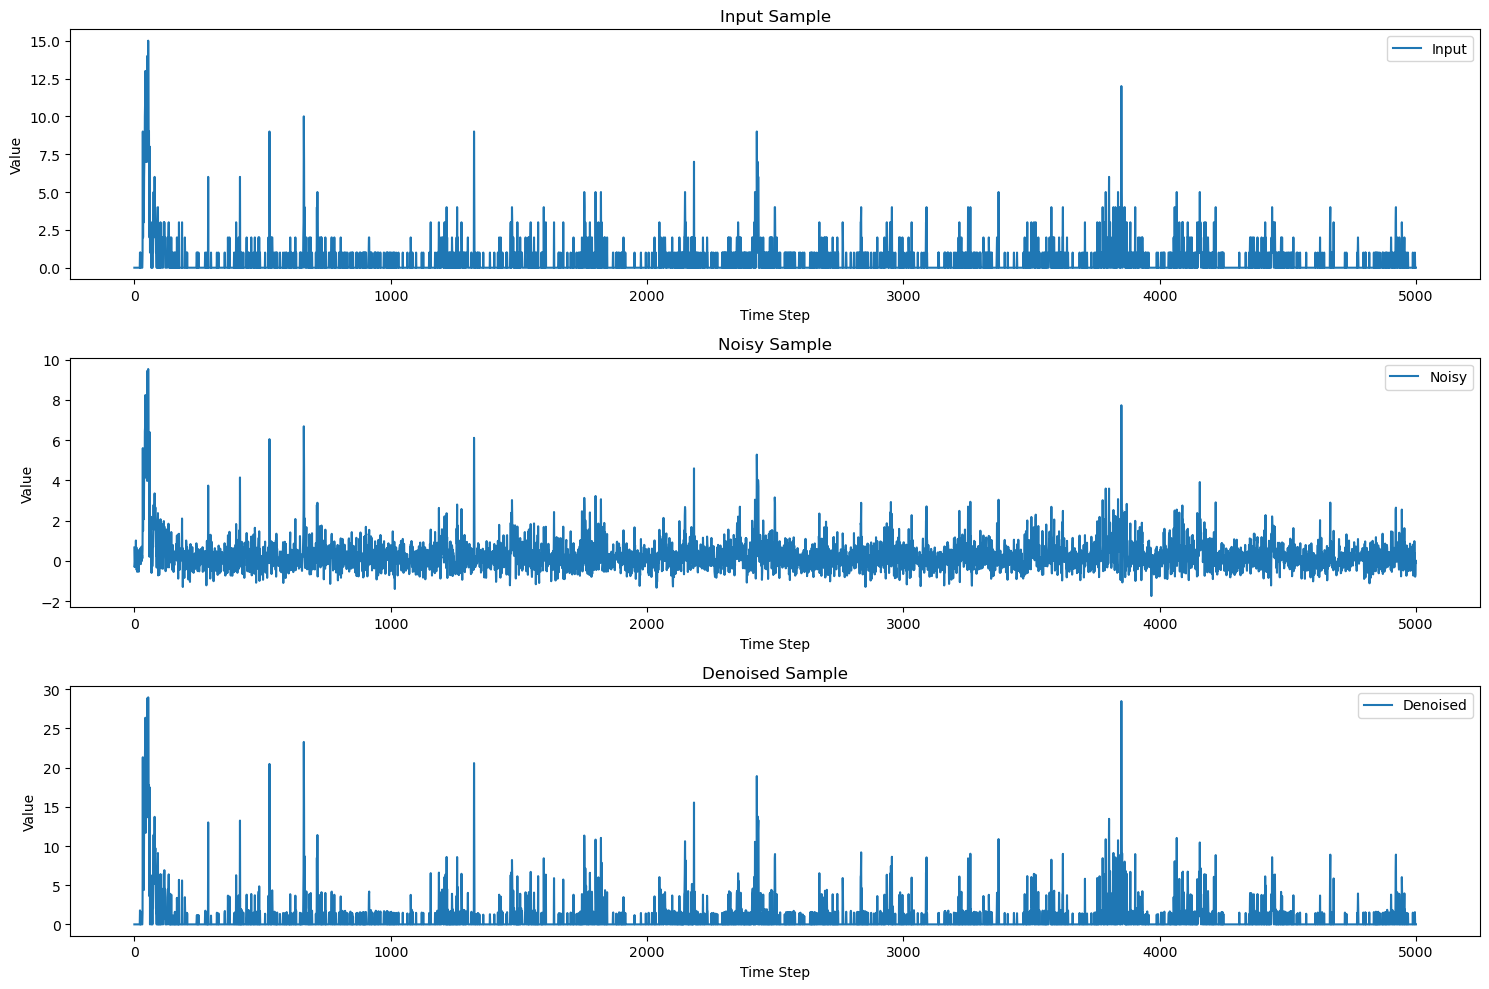

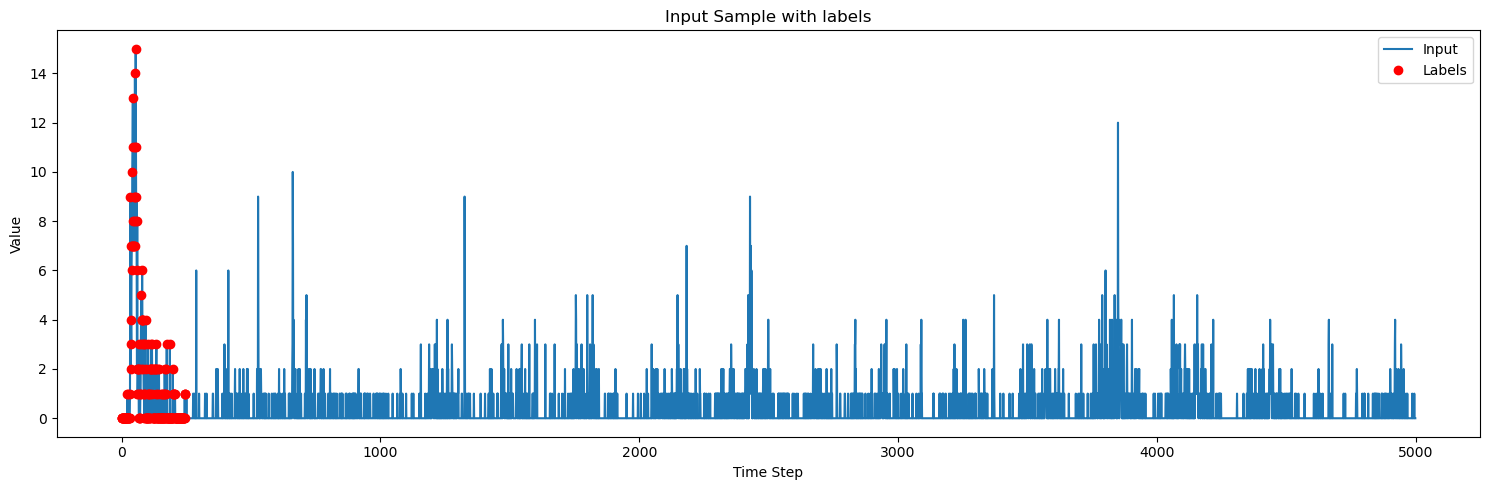

eval timesteps tensor([634, 451, 626, 721])
Best threshold: tensor(2.0974)
Best F1 score: 0.21176470588235294
Best AUPRC score: 0.08645831779102034
Best Precision score: 0.25280898876404495
Best Recall score: 0.18218623481781376
Best threshold: tensor(1.1039)
Best F1 score: 0.027586206896551724
Best AUPRC score: 0.015505956613219183
Best Precision score: 0.01675977653631285
Best Recall score: 0.07792207792207792
Best threshold: tensor(0.5520)
Best F1 score: 0.1319073083778966
Best AUPRC score: 0.08149127348806288
Best Precision score: 0.08638132295719844
Best Recall score: 0.27889447236180903
Best threshold: tensor(0.5520)
Best F1 score: 0.13012895662368112
Best AUPRC score: 0.08106765017749298
Best Precision score: 0.08486238532110092
Best Recall score: 0.27889447236180903
F1 score: 0.1253467944451206
AUPRC score: 0.06613079951744885
Precision score: 0.11020311839466429
Recall score: 0.20447431436587743

# Complete Evaluation

In [12]:
class Config:
    def __init__(self, config_dict):
        for key, value in config_dict.items():
            setattr(self, key, value)

In [13]:
# plot functions : 
def plot_samples(sample, noisy_sample, denoised_sample):  
    fig, axs = plt.subplots(3, 1, figsize=(15, 10))
    ax = axs[0]
    ax.plot(sample.cpu().numpy())
    ax.set_title("Input Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Input"])
    
    ax = axs[1]
    ax.plot(noisy_sample.cpu().numpy())
    ax.set_title("Noisy Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Noisy"])
    
    ax = axs[2]
    ax.plot(denoised_sample.cpu().numpy())
    ax.set_title("Denoised Sample")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend(["Denoised"])
    
    plt.tight_layout()
    plt.show()

def plot_predictions(sample, denoised_sample, outliers, labels):
    
    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    outlier_indices = np.where(outliers[0] == 1)[0]
    ax.plot(outlier_indices, sample[0][outlier_indices].cpu().numpy(), 'ro', label="Outliers")

    ax.set_title("Input Sample with Outliers")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

    # in the same graph visualize the input sample and the predicted outliers and the labels
    fig, ax = plt.subplots(figsize=(15, 5))
    ax.plot(sample[0].cpu().numpy(), label="Input")

    label_indices = np.where(labels[0] == True)[0]
    ax.plot(label_indices, sample[0][label_indices].cpu().numpy(), 'ro', label="Labels")
    
    ax.set_title("Input Sample with labels")
    ax.set_xlabel("Time Step")
    ax.set_ylabel("Value")
    ax.legend()
    plt.tight_layout()
    plt.show()

In [28]:
def trainer(config, model, noise_scheduler, dataset):
    
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )

    # the training loop
    global_step = 0
    frames = []
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        #progress_bar = tqdm(total=len(dataloader))
        #progress_bar.set_description(f"Epoch {epoch}")
        
        for step, (batch, labels) in enumerate(dataloader):
            std_data = torch.std(batch)
            
            noise = torch.randn_like(batch)
            
            timesteps = torch.randint(
                0, noise_scheduler.num_timesteps, (batch.shape[0],)
            ).long()
            
            #print("timesteps", timesteps)
            
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            
            noisy = noisy.unsqueeze(-1) 
            # pred noise from the model
            noise_pred = model(noisy)
            
            #print("noise_pred", noise_pred.shape)
            batch = batch.unsqueeze(-1)
            
            loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

        #progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        #progress_bar.set_postfix(**logs)
        global_step += 1
    
    #progress_bar.close()              
    return model, losses

In [ ]:
def trainer_all_in_one(config, model, noise_scheduler, dataset):
    
    dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )

    # the training loop
    global_step = 0
    frames = []
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        #progress_bar = tqdm(total=len(dataloader))
        #progress_bar.set_description(f"Epoch {epoch}")
        
        for step, (batch, labels) in enumerate(dataloader):
            std_data = torch.std(batch)
            
            noise = torch.randn_like(batch)
            
            timesteps = torch.randint(
                0, noise_scheduler.num_timesteps, (batch.shape[0],)
            ).long()
            
            #print("timesteps", timesteps)
            
            noisy = noise_scheduler.add_noise(batch, noise, timesteps)
            
            noisy = noisy.unsqueeze(-1) 
            # pred noise from the model
            noise_pred = model(noisy)
            
            #print("noise_pred", noise_pred.shape)
            batch = batch.unsqueeze(-1)
            
            loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            optimizer.zero_grad()

            #progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "step": global_step}
            losses.append(loss.detach().item())
            #progress_bar.set_postfix(**logs)
            global_step += 1
    
    #progress_bar.close()              
    return model, losses

In [15]:
def train_tracker(config, model, dataset):
    # save the model, losses, and all the config parameters in a directory 
    import os
    import json
    import matplotlib.pyplot as plt

    # output dir contains the num epochs 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    # create the directory if it does not exist
    os.makedirs(output_dir, exist_ok=True) 

    # Save the model
    model_path = os.path.join(output_dir, "model.pth")
    torch.save(model.state_dict(), model_path)

    # Save the losses and other parameters in a json file 
    losses_path = os.path.join(output_dir, "losses.json")
    with open(losses_path, "w") as f:
        json.dump(losses, f)
        
    # Save the config 
    config_path = os.path.join(output_dir, "config.json")
    with open(config_path, "w") as f:
        json.dump(vars(config), f)

    # Save the losses plot
    # Plot the loss
    plt.plot(losses)
    plt.title("Loss")
    plt.xlabel("Step")
    plt.ylabel("Loss")
    
    # Save the plot before showing it
    losses_plot_path = os.path.join(output_dir, "losses_plot.png")
    plt.savefig(losses_plot_path)
    
    # Display the plot
    plt.show()
        
    """print("Model saved at", model_path)
    print("Losses saved at", losses_path)
    print("Config saved at", config_path)
    print("Loss plot saved at", losses_plot_path)"""

    return model, losses


In [27]:
def tester(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    for step, (sample, labels) in enumerate(test_dataloader):
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
                
            #noise_level = 0.5
            #noise = torch.randn_like(sample) * std_data * noise_level
            noise = torch.randn_like(sample) 
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(noisy_sample)

            labels = labels.cpu().numpy()
                
            best_f1 = 0
            best_threshold = 0
            best_auprc = 0
            # computing the best threshold for the outliers
            for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                
                f1 = 0
                auprc = 0
                
                # calculate the f1 score and auprc score
                for i in range(len(outliers)):
                    f1_temp, auprc_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    f1 += f1_temp
                    auprc += auprc_temp
                
                f1 = f1 / len(outliers)
                auprc = auprc / len(outliers)
         
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_auprc = auprc
                
            print("F1 score:", best_f1)
            print("AUPRC score:", best_auprc)
            
            # save results in output directory
            results = {
                "std_data": std_data.item(),  # Convert tensor to a scalar
                "f1": best_f1,
                "auprc": best_auprc,
                "threshold": best_threshold  # Convert tensor to a scalar
            }
            
            # Convert the results dictionary to a DataFrame and concatenate with the existing results_df
            results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
            
            # plot one random sample 
            if step == 10:
                plot_samples(sample[10], noisy_sample[10], denoised_sample[10])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
                
    # save as a csvfile 
    results_df.to_csv(os.path.join(output_dir, "results.csv"))
    
    average_f1 += best_f1
    average_auprc += best_auprc
            
    average_f1 = average_f1 / len(test_dataloader)
    average_auprc = average_auprc / len(test_dataloader)
    
    print("Average F1 score:", average_f1)
    print("Average AUPRC score:", average_auprc)
    
    return average_f1, average_auprc


In [ ]:
def tester_bis(config, model, noise_scheduler, test_dataset): 
    output_dir = os.path.join(config.output_dir, str(config.num_epochs))
    
    # Create dataloader for the test dataset
    test_dataloader = DataLoader(test_dataset, batch_size=config.eval_batch_size, shuffle=False, drop_last=True)
    
    model.eval()
    eval_batch_size = config.eval_batch_size
    
    average_f1 = 0
    average_auprc = 0
    
    results_df = pd.DataFrame(columns=["std_data", "f1", "auprc", "threshold"])

    for step, (sample, labels) in enumerate(test_dataloader):
        
        std_data = torch.std(sample)
        
        # after sampling random noise, predict using the model to denoise the sample
        with torch.no_grad():
            timesteps = torch.randint(0, 50 , (eval_batch_size,)).long()
                
            #noise_level = 0.5
            #noise = torch.randn_like(sample) * std_data * noise_level
            noise = torch.randn_like(sample) 
            noisy_sample = noise_scheduler.add_noise(sample, noise, timesteps)
            
            noisy_sample = noisy_sample.unsqueeze(-1)
            sample = sample.unsqueeze(-1)
            denoised_sample = model(noisy_sample)

            labels = labels.cpu().numpy()
                
            best_f1 = 0
            best_threshold = 0
            best_auprc = 0
            # computing the best threshold for the outliers
            for threshold in torch.arange(std_data * 0.5, std_data * 2.5, std_data * 0.2):
                outliers = (torch.abs(sample - denoised_sample) > threshold).cpu().numpy()
                
                f1 = 0
                auprc = 0
                
                # calculate the f1 score and auprc score
                for i in range(len(outliers)):
                    f1_temp, auprc_temp = calculate_f1_auprc_score(labels[i], outliers[i])
                    f1 += f1_temp
                    auprc += auprc_temp
                
                f1 = f1 / len(outliers)
                auprc = auprc / len(outliers)
         
                if f1 > best_f1:
                    best_f1 = f1
                    best_threshold = threshold
                    best_auprc = auprc
                
            print("F1 score:", best_f1)
            print("AUPRC score:", best_auprc)
            
            # save results in output directory
            results = {
                "std_data": std_data.item(),  # Convert tensor to a scalar
                "f1": best_f1,
                "auprc": best_auprc,
                "threshold": best_threshold  # Convert tensor to a scalar
            }
            
            # Convert the results dictionary to a DataFrame and concatenate with the existing results_df
            results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
            
            # plot one random sample 
            if step == 10:
                plot_samples(sample[10], noisy_sample[10], denoised_sample[10])
                plot_predictions(sample, denoised_sample, outliers, labels)
                
                
    # save as a csvfile 
    results_df.to_csv(os.path.join(output_dir, "results.csv"))
    
    average_f1 += best_f1
    average_auprc += best_auprc
            
    average_f1 = average_f1 / len(test_dataloader)
    average_auprc = average_auprc / len(test_dataloader)
    
    print("Average F1 score:", average_f1)
    print("Average AUPRC score:", average_auprc)
    
    return average_f1, average_auprc


In [31]:
# f1 score and auprc score for 0/1 classification

from sklearn.metrics import f1_score, average_precision_score

# define the function to calculate the f1 score and auprc score
def calculate_f1_auprc_score(y_true, y_pred):
    f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0 ) #, labels=np.unique(y_pred) zero_division=np.nan
    auprc = average_precision_score(y_true, y_pred, average='weighted')
    return f1, auprc

## WSD dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from pytorch_tcn import TCN  # Import the TCN class from pytorch-tcn

sequence_length = 5000
input_size = 1  # Assuming 1D time series data

base_config = {
  "data_path": "../datasets/UTS/WSD/107",
  "output_dir": "output_WSD",
  "train_batch_size": 16,
  "eval_batch_size": 1,
  "num_epochs": 5,
  
  "learning_rate": 0.0001,
  "num_timesteps": 1000,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.0001,
  "beta_end": 0.02,
  "save_model_epochs": 1
}

In [ ]:
import os

data_folder = "../datasets/UTS/NAB"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_WSD", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[64, 128, 256, 512,256,128,64,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=5000, stride=500,normalize=False)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=5000, stride=500, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


# NAB dataset

In [32]:

base_config = {
  "data_path":  "../datasets/UTS/NAB/Twitter_volume_AAPL",
  "output_dir": "output",
  "train_batch_size": 8,
  "eval_batch_size": 8,
  "num_epochs": 12,
  
  "learning_rate": 0.0001,
  "num_timesteps": 100,
  "beta_schedule": "linear",
  "embedding_size": 128,
  "hidden_size": 128,
  "hidden_layers": 3,
  "time_embedding": "sinusoidal",
  "input_embedding": "sinusoidal",
  "save_eval_step": 10,
  "experiment_name": "NonName",
  "beta_start": 0.01,
  "beta_end": 0.2,
  "save_model_epochs": 1
}


{'data_path': '../datasets/UTS/NAB/Twitter_volume_AAPL', 'output_dir': 'output_NAB/Twitter_volume_AAPL', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_AAPL
Training model...


  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


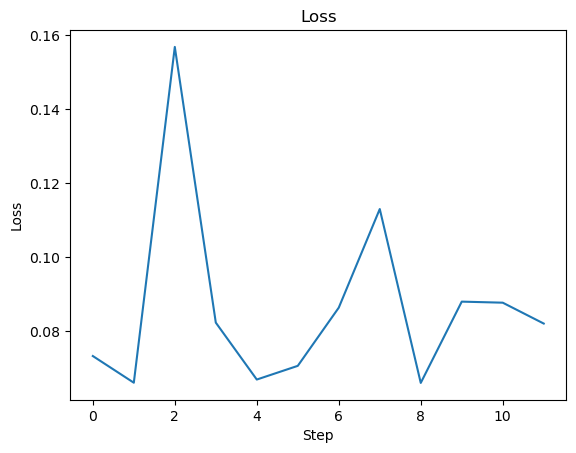

F1 score: 0.6606788909034665
AUPRC score: 0.2961833419418375
F1 score: 0.742809837848409
AUPRC score: 0.21416194755931267


/tmp/ipykernel_159549/2433626349.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one

F1 score: 0.9972353700591328
AUPRC score: 0.0
F1 score: 0.9954260499551232
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9970566960918968
AUPRC score: 0.0
F1 score: 0.9978687997832324
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9980363321549609
AUPRC score: 0.0
F1 score: 0.9994146030419209
AUPRC score: 0.0
Average F1 score: 0.12492682538024011
Average AUPRC score: 0.0
training and results done for Twitter_volume_AAPL
{'data_path': '../datasets/UTS/NAB/Twitter_volume_AMZN', 'output_dir': 'output_NAB/Twitter_volume_AMZN', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_AMZN
Training model...


100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


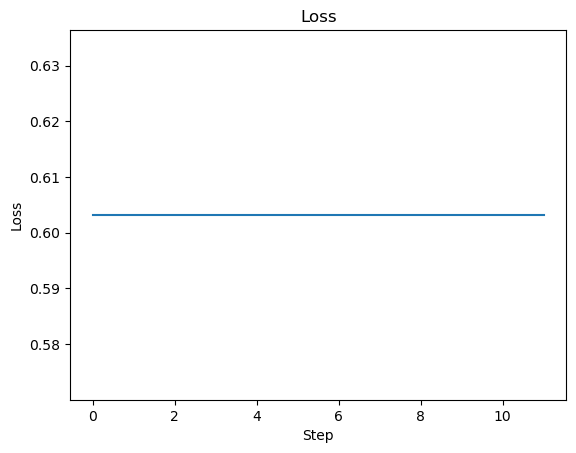

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.7740764975416339
AUPRC score: 0.14600137672967212
F1 score: 0.6540573921510255
AUPRC score: 0.2929131682637705
F1 score: 0.7959162831614537
AUPRC score: 0.21141087863609442
F1 score: 0.6796692689697948
AUPRC score: 0.3076965118420741


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.759731655348389
AUPRC score: 0.2249966469327044
F1 score: 0.7358967191502281
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.7266117274277933
AUPRC score: 0.0
F1 score: 0.7868749794787624
AUPRC score: 0.0
Average F1 score: 0.0983593724348453
Average AUPRC score: 0.0
training and results done for Twitter_volume_AMZN
{'data_path': '../datasets/UTS/NAB/Twitter_volume_CRM', 'output_dir': 'output_NAB/Twitter_volume_CRM', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_CRM
Training model...


100%|██████████| 12/12 [00:10<00:00,  1.10it/s]


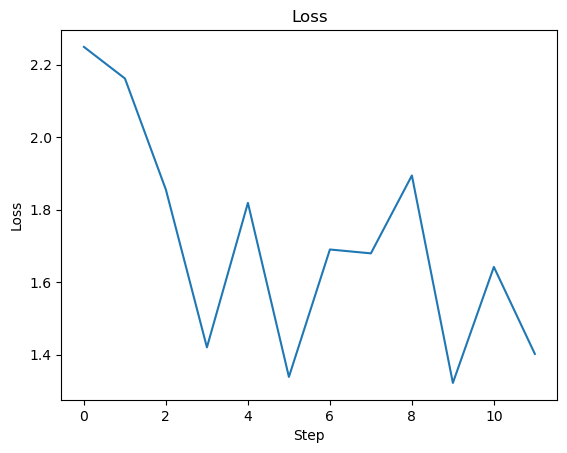

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9132400600563968
AUPRC score: 0.09077044487008923
F1 score: 0.9981586226948759
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9962547557424825
AUPRC score: 0.0
F1 score: 0.9967108970337837
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9987442749657294
AUPRC score: 0.0
F1 score: 0.9973105400593203
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9919208080599994
AUPRC score: 0.0
F1 score: 0.9986145327414726
AUPRC score: 0.0
Average F1 score: 0.12482681659268408
Average AUPRC score: 0.0
training and results done for Twitter_volume_CRM
{'data_path': '../datasets/UTS/NAB/Twitter_volume_CVS', 'output_dir': 'output_NAB/Twitter_volume_CVS', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_CVS
Training model...


100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


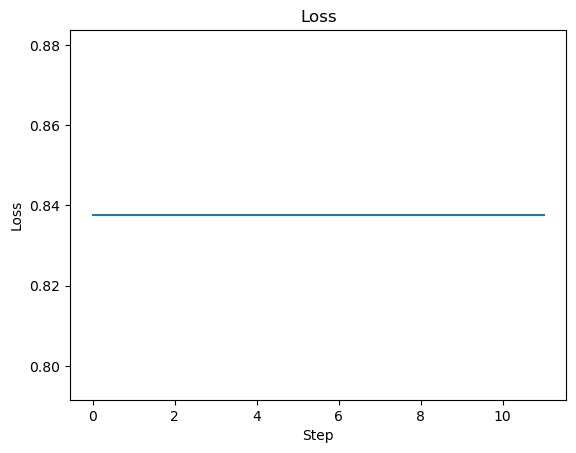

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9435315891477758
AUPRC score: 0.04804032544191765
F1 score: 0.9592677703148129
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9635022234665345
AUPRC score: 0.0
F1 score: 0.9805863179204449
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9823562530935481
AUPRC score: 0.0
F1 score: 0.7209031704997713
AUPRC score: 0.2215705890630481


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.6495642763693744
AUPRC score: 0.2636776491690075
F1 score: 0.9471287998415655
AUPRC score: 0.030362643820251205
Average F1 score: 0.11839109998019569
Average AUPRC score: 0.0037953304775314007
training and results done for Twitter_volume_CVS
{'data_path': '../datasets/UTS/NAB/Twitter_volume_FB', 'output_dir': 'output_NAB/Twitter_volume_FB', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_FB
Training model...


100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


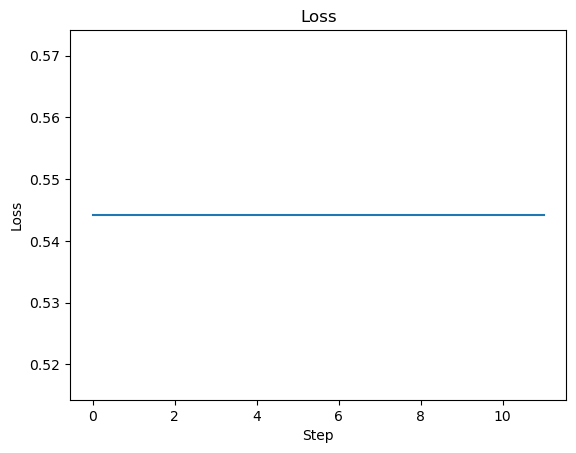

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.8933056389274598
AUPRC score: 0.02366655319232213
F1 score: 0.47091608225626763
AUPRC score: 0.40286289257065216
F1 score: 0.41385712699458366
AUPRC score: 0.4620306136236649


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.8613733806705595
AUPRC score: 0.08388536210723903
F1 score: 0.9391354856485116
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9465109341941561
AUPRC score: 0.0
F1 score: 0.9261213925223877
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9251503414416492
AUPRC score: 0.0
Average F1 score: 0.11564379268020615
Average AUPRC score: 0.0
training and results done for Twitter_volume_FB
{'data_path': '../datasets/UTS/NAB/Twitter_volume_GOOG', 'output_dir': 'output_NAB/Twitter_volume_GOOG', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_GOOG
Training model...


100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


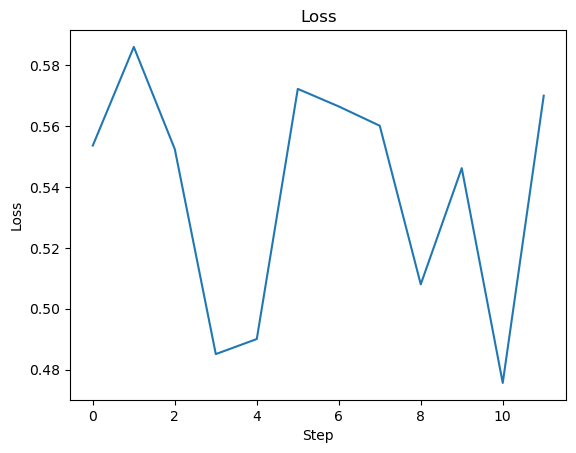

F1 score: 0.7783342096939007
AUPRC score: 0.2877383968404344
F1 score: 0.7922335917630514
AUPRC score: 0.5130332950872268


/tmp/ipykernel_159549/2433626349.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one

F1 score: 0.956204292796323
AUPRC score: 0.13864897783189276
F1 score: 0.9970960484957428
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9910417337195581
AUPRC score: 0.0
F1 score: 0.9991641020399169
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9984065622611966
AUPRC score: 0.0
F1 score: 0.9977765995322585
AUPRC score: 0.0
Average F1 score: 0.12472207494153231
Average AUPRC score: 0.0
training and results done for Twitter_volume_GOOG
{'data_path': '../datasets/UTS/NAB/Twitter_volume_IBM', 'output_dir': 'output_NAB/Twitter_volume_IBM', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_IBM
Training model...


100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


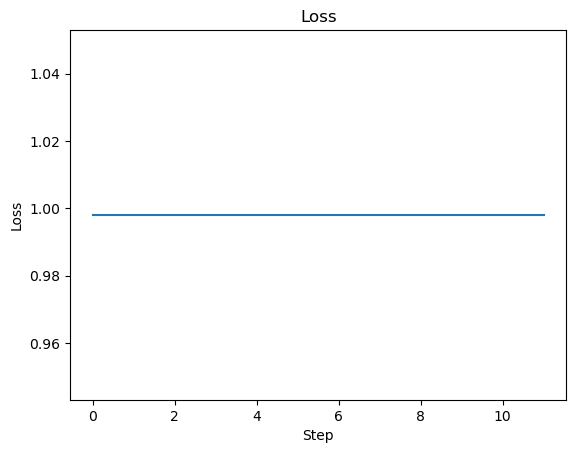

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9523898583392251
AUPRC score: 0.0
F1 score: 0.9595242793791066
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9794014501787127
AUPRC score: 0.0
F1 score: 0.9746721289496727
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9500786404127556
AUPRC score: 0.0
F1 score: 0.9776757730068769
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.970790961594796
AUPRC score: 0.008116899391335482
F1 score: 0.6281062033255681
AUPRC score: 0.401175565416629
Average F1 score: 0.07851327541569601
Average AUPRC score: 0.05014694567707863
training and results done for Twitter_volume_IBM
{'data_path': '../datasets/UTS/NAB/Twitter_volume_KO', 'output_dir': 'output_NAB/Twitter_volume_KO', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_KO
Training model...


100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


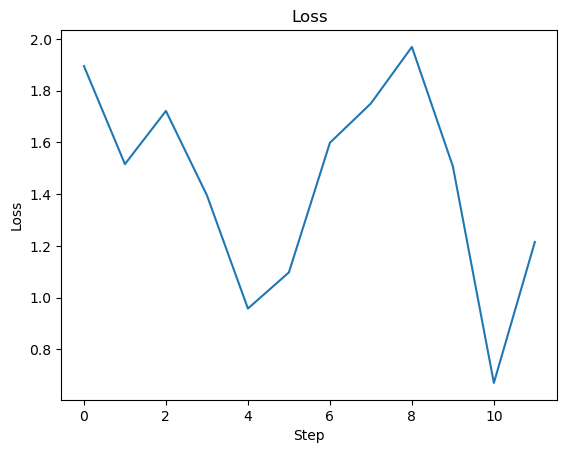

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9979911768292189
AUPRC score: 0.0
F1 score: 0.9985782270913247
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.973290214471824
AUPRC score: 0.0187776008492569
F1 score: 0.5954513730975317
AUPRC score: 0.3250838718842773
F1 score: 0.5624166930648322
AUPRC score: 0.33767212462244983
F1 score: 0.5563472240986049
AUPRC score: 0.33105913430258743


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.5646306886985037
AUPRC score: 0.3288286103960353
F1 score: 0.9628162769943099
AUPRC score: 0.02416666666666667
Average F1 score: 0.12035203462428874
Average AUPRC score: 0.0030208333333333337
training and results done for Twitter_volume_KO
{'data_path': '../datasets/UTS/NAB/Twitter_volume_PFE', 'output_dir': 'output_NAB/Twitter_volume_PFE', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_PFE
Training model...


100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


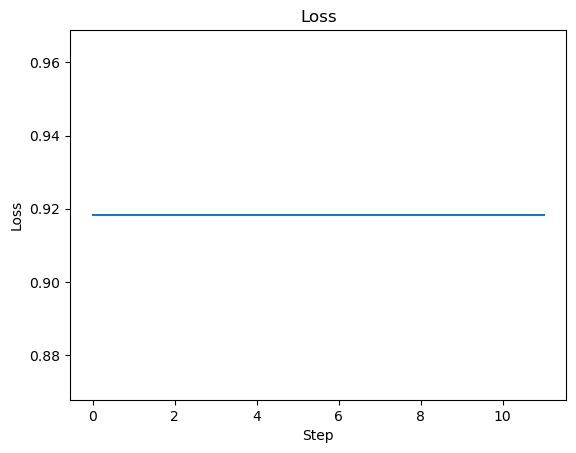

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.95938628102643
AUPRC score: 0.0
F1 score: 0.9747926122918457
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.8829457967465246
AUPRC score: 0.08431350280927291
F1 score: 0.6694873984233394
AUPRC score: 0.29823342964546584


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.7902417990362836
AUPRC score: 0.1757625547913258
F1 score: 0.9777078133237206
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9693370468941538
AUPRC score: 0.0
F1 score: 0.976146295412471
AUPRC score: 0.0
Average F1 score: 0.12201828692655887
Average AUPRC score: 0.0
training and results done for Twitter_volume_PFE
{'data_path': '../datasets/UTS/NAB/Twitter_volume_UPS', 'output_dir': 'output_NAB/Twitter_volume_UPS', 'train_batch_size': 8, 'eval_batch_size': 8, 'num_epochs': 12, 'learning_rate': 0.0001, 'num_timesteps': 100, 'beta_schedule': 'linear', 'embedding_size': 128, 'hidden_size': 128, 'hidden_layers': 3, 'time_embedding': 'sinusoidal', 'input_embedding': 'sinusoidal', 'save_eval_step': 10, 'experiment_name': 'NonName', 'beta_start': 0.01, 'beta_end': 0.2, 'save_model_epochs': 1}
../datasets/UTS/NAB/Twitter_volume_UPS
Training model...


100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


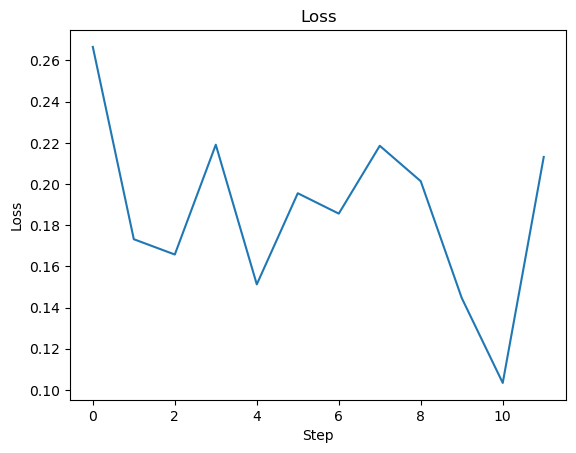

/tmp/ipykernel_159549/2433626349.py:70: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame([results])], ignore_index=True)


F1 score: 0.7151674982829416
AUPRC score: 0.23934454189270074
F1 score: 0.9261961212347241
AUPRC score: 0.048069790369447904


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9958915566169734
AUPRC score: 0.0
F1 score: 0.9974088637101021
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9977852157429072
AUPRC score: 0.0
F1 score: 0.9963144986444188
AUPRC score: 0.0


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

F1 score: 0.9960458267803198
AUPRC score: 0.0
F1 score: 0.9956764454621897
AUPRC score: 0.0
Average F1 score: 0.12445955568277371
Average AUPRC score: 0.0
training and results done for Twitter_volume_UPS


/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/sklearn/metrics/_ranking.py:1030: UserWarning: No positive class found in y_true, recall is set to one fo

In [33]:
import os

sequence_length = 1500
input_size = 1
data_folder = "../datasets/UTS/NAB"

for root, dirs, files in os.walk(data_folder):
    for dir in dirs:
        data_path = os.path.join(data_folder, dir)
    
        # change datapath in the config
        base_config["data_path"] = data_path
        base_config["output_dir"] = os.path.join("output_NAB", dir)
        
        print(base_config)
        # Create Config object
        config = Config(base_config)
        
        print(config.data_path)

        # Initialize the new TCN model
        model = TCN(
            num_inputs=input_size,  # Number of input channels
            num_channels=[32,64, 128, 256,128,64,32,1],  # Number of channels in each residual block
            kernel_size=3,  # Size of the convolution kernel
            dilations=None,  # Dilation sizes
            dilation_reset=None,  # Reset dilation size
            dropout=0.2,  # Dropout rate
            causal=True,  # Causal convolutions for real-time applications
            use_norm='weight_norm',  # Normalization method
            activation='relu',  # Activation function
            kernel_initializer='xavier_uniform',  # Weight initializer
            use_skip_connections=False,  # Skip connections
            input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
            embedding_shapes=None,  # Embedding shapes
            embedding_mode='add',  # Embedding mode ('add' or 'concat')
            use_gate=False,  # Use gated linear unit
            lookahead=0,  # Lookahead for future time steps
            output_projection=None,  # Output projection
            output_activation=None,  # Output activation
        )

        noise_scheduler = NoiseScheduler(
            num_timesteps=config.num_timesteps,
            beta_start=config.beta_start,
            beta_end=config.beta_end,
            beta_schedule=config.beta_schedule
        )

        # Set up dataset and dataloader
        dataset = TimeSeriesDataset(config.data_path,sequence_length=1500, stride=100,normalize=True)

        # Set up dataset and dataloader for test data
        test_dataset = TimeSeriesTestDataset(config.data_path, sequence_length=1500, stride=100, normalize=False) #mean=dataset.mean, std=dataset.std)

        #================================================================================================
        # define a pd dataframe to save the results, with the data folder name as the index
        results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
        results_df.set_index("data_folder", inplace=True)
        
        # train the model and test it
        model, losses = trainer(config, model, noise_scheduler, dataset)
        train_tracker(config, model, dataset)
        average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)
        
        # save the results in the dataframe
        results_df.loc[dir] = [average_f1, average_auprc]
        
        print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))


In [ ]:
# all in one training and testing
import os

# Initialize the new TCN model
model = TCN(
    num_inputs=input_size,  # Number of input channels
    num_channels=[32,64, 128, 256,128,64,32,1],  # Number of channels in each residual block
    kernel_size=3,  # Size of the convolution kernel
    dilations=None,  # Dilation sizes
    dilation_reset=None,  # Reset dilation size
    dropout=0.2,  # Dropout rate
    causal=True,  # Causal convolutions for real-time applications
    use_norm='weight_norm',  # Normalization method
    activation='relu',  # Activation function
    kernel_initializer='xavier_uniform',  # Weight initializer
    use_skip_connections=False,  # Skip connections
    input_shape='NLC',  # Input shape format ('NCL' or 'NLC') [16, 5000, 1] for NLC
    embedding_shapes=None,  # Embedding shapes
    embedding_mode='add',  # Embedding mode ('add' or 'concat')
    use_gate=False,  # Use gated linear unit
    lookahead=0,  # Lookahead for future time steps
    output_projection=None,  # Output projection
    output_activation=None,  # Output activation
)

noise_scheduler = NoiseScheduler(
    num_timesteps=config.num_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule
)

data_folder = "../datasets/UTS/NAB"


def trainer_all_in_one(config, model, noise_scheduler):

    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=config.learning_rate,
    )

    # the training loop
    global_step = 0
    frames = []
    losses = []
    print("Training model...")
    # Training over windows: The code does train over these windows. Each batch contains multiple sequences of length sequence_length.
        
    for epoch in tqdm(range(config.num_epochs)):
        model.train()
        #progress_bar = tqdm(total=len(dataloader))
        #progress_bar.set_description(f"Epoch {epoch}")
        
        for root, dirs, files in os.walk(data_folder):
            for dir in dirs:
                data_path = os.path.join(data_folder, dir)
            
                # change datapath in the config
                base_config["data_path"] = data_path
                base_config["output_dir"] = os.path.join("output_NAB", dir)
                
                print(base_config)
                # Create Config object
                config = Config(base_config)
                
                print(config.data_path)

                # Set up dataset and dataloader
                dataset = TimeSeriesDataset(config.data_path,sequence_length=1500, stride=100,normalize=True)
                
                dataloader = DataLoader(dataset, batch_size=config.train_batch_size, shuffle=False , drop_last=True)

                for step, (batch, labels) in enumerate(dataloader):
                    std_data = torch.std(batch)
                    
                    noise = torch.randn_like(batch)
                    
                    timesteps = torch.randint(
                        0, noise_scheduler.num_timesteps, (batch.shape[0],)
                    ).long()
                    
                    #print("timesteps", timesteps)
                    
                    noisy = noise_scheduler.add_noise(batch, noise, timesteps)
                    
                    noisy = noisy.unsqueeze(-1) 
                    # pred noise from the model
                    noise_pred = model(noisy)
                    
                    #print("noise_pred", noise_pred.shape)
                    batch = batch.unsqueeze(-1)
                    
                    loss = F.mse_loss(noise_pred, batch) # je vais predire la distribution de base 
                    
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()
                    optimizer.zero_grad()

        #progress_bar.update(1)
        logs = {"loss": loss.detach().item(), "step": global_step}
        losses.append(loss.detach().item())
        #progress_bar.set_postfix(**logs)
        global_step += 1
    
    #progress_bar.close()              
    return model, losses


#================================================================================================
# train the model and test it
model, losses = trainer(config, model, noise_scheduler, dataset)
train_tracker(config, model, dataset)

In [ ]:
# define a pd dataframe to save the results, with the data folder name as the index
results_df = pd.DataFrame(columns=["data_folder", "average_f1", "average_auprc"])
results_df.set_index("data_folder", inplace=True)

average_f1, average_auprc = tester(config, model, noise_scheduler, test_dataset)

# save the results in the dataframe
results_df.loc[dir] = [average_f1, average_auprc]

print("training and results done for", dir)
        
# save the results in a csv file in outtput directory
results_df.to_csv(os.path.join(config.output_dir, "results.csv"))